[View in Colaboratory](https://colab.research.google.com/github/YuliaZamriy/W207_Group_Project/blob/master/w207_openbarbell_lifter_segmentation.ipynb)

In [8]:
#!git clone https://github.com/YuliaZamriy/W207_Group_Project.git

In [9]:
# make sure Google Drive is mounted
#!ls 

In [156]:
import warnings
warnings.filterwarnings(action='once')

In [723]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import locale
import sys
import itertools
from locale import atof
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from scipy.cluster.hierarchy import fcluster

from scipy.stats import mode

%matplotlib inline

In [440]:
# Jupyter viewing options
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', 500)

# suppress scientific float notation
np.set_printoptions(precision=5, suppress=True)

In [12]:
# df = pd.read_csv("drive/Colab Notebooks/ob_data_w207_filtered.csv")

In [13]:
csv_data_file = 'ob_data_w207_filtered.csv'
zip_data_file = 'ob_data_w207_filtered.zip'

locale.setlocale(locale.LC_NUMERIC, '')

df = None
if not os.path.exists(csv_data_file) and os.path.exists(zip_data_file):
    zip_ref = zipfile.ZipFile(zip_data_file, 'r')
    zip_ref.extractall()
    zip_ref.close()
if os.path.exists(csv_data_file):
    df = pd.read_csv(csv_data_file)
    # -- pandas supposedly coverts '7,39' to '7.39' with decimal arg but it didn't work
    #df = pd.read_csv(csv_data_file, decimal='.')
else:
    raise Exception('Data file not found! {0}'.format(csv_data_file))

In [14]:
df.head(5)

,_id,deleted,endTime,exercise,initialStartTime,metric,removed_set,rpe,setID,setNumber,startTime,tags,userID,videoFileURL,videoType,weight,workoutID,RepCount,isValid,removed_rep,hardware,appVersion,deviceName,deviceIdentifier,time,StartMessg,RepN,AvgVel,ROM,PeakVel,PeakVelLoc,StartData,RepDur,TimeBWReps,TimeRepComp,TimeRepWait,SlowAllow,Backlight,MinAllow,PeakAccel,_merge,rpe_num,weight_lbs,exercise_clean,exercise_clean2
0,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,NaN,[],5a2e998b05cbc9b8ef26ac7e,assets-library://asset/asset.mov?id=CFFFFAC8-0...,lift,87.5,5bac5444-7c37-49d0-be8e-32be1a09fbb1,0.0,True,False,ios,3.2.3,OB 6666,709A15B7-B43C-AF0E-953A-6D4CEFEB4C83,2018-01-03 01:29:46.902,-3456.0,11.0,0.258460,252.0,0.308408,37.0,NaN,978699.0,0.0,1.752134e+09,0.0,130000.0,10000.0,150000.0,11.073610,both,7.5,192.90425,bench,bench
1,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,NaN,[],5a2e998b05cbc9b8ef26ac7e,assets-library://asset/asset.mov?id=CFFFFAC8-0...,lift,87.5,5bac5444-7c37-49d0-be8e-32be1a09fbb1,1.0,True,False,ios,3.2.3,OB 6666,709A15B7-B43C-AF0E-953A-6D4CEFEB4C83,2018-01-03 01:29:49.526,-3456.0,12.0,0.273285,250.0,0.368293,72.0,NaN,915894.0,0.0,1.754801e+09,0.0,130000.0,10000.0,150000.0,0.714399,both,7.5,192.90425,bench,bench
2,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,NaN,[],5a2e998b05cbc9b8ef26ac7e,assets-library://asset/asset.mov?id=CFFFFAC8-0...,lift,87.5,5bac5444-7c37-49d0-be8e-32be1a09fbb1,2.0,True,False,ios,3.2.3,OB 6666,709A15B7-B43C-AF0E-953A-6D4CEFEB4C83,2018-01-03 01:29:52.272,-3456.0,13.0,0.268205,263.0,0.378763,72.0,NaN,983460.0,0.0,1.757625e+09,0.0,130000.0,10000.0,150000.0,0.730685,both,7.5,192.90425,bench,bench
3,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,NaN,[],5a2e998b05cbc9b8ef26ac7e,assets-library://asset/asset.mov?id=CFFFFAC8-0...,lift,87.5,5bac5444-7c37-49d0-be8e-32be1a09fbb1,3.0,True,False,ios,3.2.3,OB 6666,709A15B7-B43C-AF0E-953A-6D4CEFEB4C83,2018-01-03 01:29:55.633,-3456.0,14.0,0.268338,252.0,0.392775,72.0,NaN,942963.0,0.0,1.760793e+09,0.0,130000.0,10000.0,150000.0,0.923557,both,7.5,192.90425,bench,bench
4,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,NaN,[],5a2e998b05cbc9b8ef26ac7e,assets-library://asset/asset.mov?id=CFFFFAC8-0...,lift,87.5,5bac5444-7c37-49d0-be8e-32be1a09fbb1,4.0,True,False,ios,3.2.3,OB 6666,709A15B7-B43C-AF0E-953A-6D4CEFEB4C83,2018-01-03 01:29:58.932,-3456.0,15.0,0.254381,250.0,0.389622,77.0,NaN,983978.0,0.0,1.764224e+09,0.0,130000.0,10000.0,150000.0,0.827607,both,7.5,192.90425,bench,bench


In [15]:
print("Data shape: {0}".format(df.shape))

Data shape: (292910, 45)


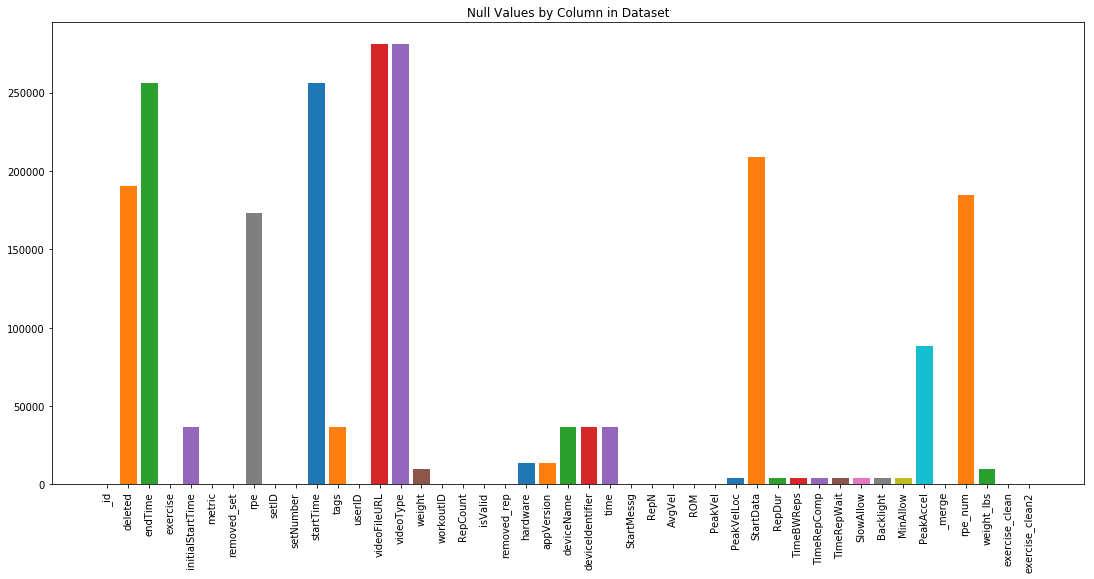

In [16]:
null_sums = df.isnull().sum()
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 8.5)
for i, null_col in enumerate(null_sums):
    plt.bar(i, null_col)

plt.title('Null Values by Column in Dataset')
plt.xticks(list(range(len(null_sums))), null_sums.index, rotation='vertical')
plt.show()

In [17]:
def get_label_distribution(label):
    i, j = np.unique(label, return_counts = True)
    return pd.DataFrame({"Exercise": i, "Row count": j})
        
        
get_label_distribution(df['exercise_clean'])

,Exercise,Row count
0,bench,94640
1,bench other,35117
2,deadlift,35966
3,deadlift other,7366
4,squat,77680
5,squat other,42141


### Potential features to consider for lifter segmentation:

 Lifting-related:
 
 - `rpe_num`: uses RPE or not
 - `weight_lbs`
 - `RepCount`: values start from 0 (counts of 1); higher repper vs. low
 - `ROM`
 - `AvgVel`
 - `PeakVel`
 - `PeakVelLoc`
 - `RepDur`
 - `PeakAccel`


User-related:

 - `initialStartTime` / `startTime` / `time`
 - `tags`: tagger or not
 - `workoutID`: number of unique workouts
 - `hardware`:  two values: (ios, android)
 - `deviceName`/`deviceIdentifier`:  how many devices is using
 
 
 ### Potential lifter identifiers:
 
 - Primary: `userID`
 - Secondary:`exercise_clean`


## EDA for Lifter Segmentation

In [515]:
def check_frequency(feature):
    counts = feature.value_counts()
    print(f"\n{feature.name} has {counts.shape[0]} unique values")
    print("Top 10 values are:")
    if counts.shape[0] > 10:
          print(counts[:10])
    else:
          print(counts)

In [516]:
check_frequency(df['appVersion'])


appVersion has 24 unique values
Top 10 values are:
3.2.3    67488
3.3.1    65767
3.0.3    30518
3.3.0    30365
1.5.2    13119
3.1.5    10387
3.2.0     9151
3.0.0     8926
3.1.4     6909
1.5.3     6842
Name: appVersion, dtype: int64


In [517]:
ls_discrete_features = ['hardware', 'rpe_num', 'RepCount', 'tags', 'deviceName']
for v in ls_discrete_features:
    check_frequency(df[v])


hardware has 2 unique values
Top 10 values are:
ios        189386
android     89821
Name: hardware, dtype: int64

rpe_num has 45 unique values
Top 10 values are:
8.0     21131
7.0     21067
6.0     14131
5.5     12783
7.5      9561
9.0      8933
8.5      7849
6.5      6294
10.0     3354
Name: rpe_num, dtype: int64

RepCount has 115 unique values
Top 10 values are:
0.0     66760
1.0     61538
2.0     52633
3.0     35216
4.0     26591
5.0     15191
6.0      9561
7.0      7190
8.0      4404
9.0      3315
10.0     1801
Name: RepCount, dtype: int64

tags has 4097 unique values
Top 10 values are:
[]              148087
['Belt']          5788
['warmup']        3570
['belt']          2629
['Duffalo']       1836
['beltless']      1691
['Beltless']      1516
['warm up']       1422
['no belt ']      1405
['Speed']         1398
Name: tags, dtype: int64

deviceName has 343 unique values
Top 10 values are:
OB 3248    9059
OB 6666    6897
OB 2257    6748
OB 3434    6059
OB 3302    5812
OB 3162    56

In [291]:
def get_descr(data, features):
    data_descr = data[features].describe()
    pct_missing = pd.Series(100-np.around(data_descr.loc['count',]/data.shape[0]*100,2))
    pct_missing.name = 'pct_missing'
    pct_zero = pd.Series([100*sum(data[v] == 0)/data.shape[0] for v in features])
    pct_zero.name = 'pct_zeros'
    pct_zero.index = pct_missing.index
    data_descr = data_descr.append(pct_missing)
    data_descr = data_descr.append(pct_zero)
    return data_descr
  
ls_cont_features = ['rpe_num', 'RepCount', 'weight_lbs', 'AvgVel',
                    'ROM', 'PeakVel', 'PeakVelLoc', 'RepDur', 'PeakAccel']

get_descr(df, ls_cont_features)

,rpe_num,RepCount,weight_lbs,AvgVel,ROM,PeakVel,PeakVelLoc,RepDur,PeakAccel
count,107928.000000,292910.000000,283142.000000,292891.000000,292910.000000,292910.000000,288513.000000,2.885130e+05,204717.000000
mean,7.330340,2.775013,235.271909,0.479184,462.061456,0.771857,72.132299,1.102977e+06,15.439559
std,1.201296,4.143754,105.251502,0.223486,157.312786,0.377337,20.038203,4.745798e+05,59.320897
min,5.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,6.500000,1.000000,165.000000,0.320720,326.000000,0.483974,65.000000,7.656250e+05,3.307050
50%,7.000000,2.000000,225.000000,0.435733,450.000000,0.718287,79.000000,1.030670e+06,6.186958
75%,8.000000,4.000000,300.000000,0.591369,598.000000,0.976293,87.000000,1.363892e+06,12.775880
max,10.000000,114.000000,1000.000000,2.960175,1761.000000,5.560000,99.000000,1.129953e+07,2686.953000
pct_missing,63.150000,0.000000,3.330000,0.010000,0.000000,0.000000,1.500000,1.500000e+00,30.110000
pct_zeros,0.000000,22.791984,0.130415,0.001366,0.001366,0.001366,0.013997,6.145232e-03,0.017411


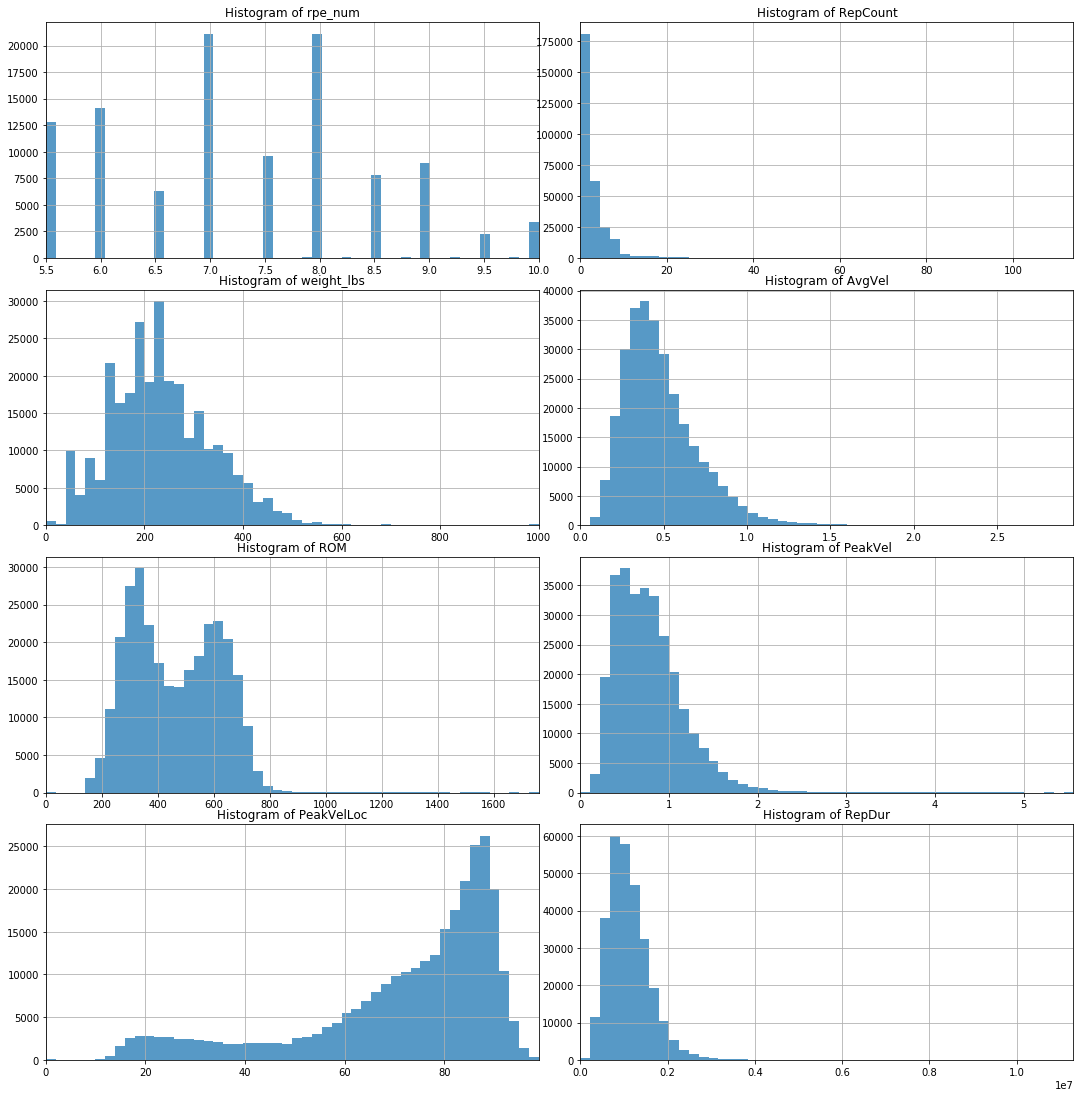

In [21]:
def plot_multi_hist(data, features):
  nrows = len(features)//2
  ncols = min(len(features), 2)
  fig, axs = plt.subplots(nrows, ncols, figsize=(15,15))
  fig.tight_layout()
  for ax, index in zip(axs.ravel(), range(len(features))):
    bins = 50
    adj = 10
    xmin = np.min(data[features[index]])
    xmax = np.max(data[features[index]])
    x99 = np.nanpercentile(data[features[index]], 99)
    if xmax/x99 > adj:
      xmax = x99/2
      bins *= adj*5
    ax.hist(data[features[index]].dropna(), bins, alpha=0.75)
    ax.set_title(f'Histogram of {features[index]}')
    ax.set_xlim([xmin, xmax])
    ax.grid(True)
  plt.show()
  
plot_multi_hist(df, ls_cont_features)

## Figuring out lifter id

In [22]:
def feature_descr(feature):
  print(f"{feature.name} Summary:")
  print(feature.describe())
  
  print(f"\nLow occurrence for {feature.name}:")
  for i in range(1, 10):
    print(f"There are {sum(feature==i)} unique values with {i} observation(s)")
  
  print(f"\n{feature.name} Histogram:")
  xmin, xmax = np.min(feature), np.nanpercentile(feature, 99)
  plt.hist(feature, 100, facecolor = 'g', alpha = 0.75)
  plt.xlim([xmin, xmax])
  plt.show()

In [23]:
userID_count = df['userID'].value_counts()
userID_count.shape

(460,)

userID Summary:
count      460.000000
mean       636.760870
std       1257.673288
min          1.000000
25%         27.750000
50%        111.500000
75%        571.250000
max      10568.000000
Name: userID, dtype: float64

Low occurrence for userID:
There are 2 unique values with 1 observation(s)
There are 4 unique values with 2 observation(s)
There are 8 unique values with 3 observation(s)
There are 6 unique values with 4 observation(s)
There are 6 unique values with 5 observation(s)
There are 6 unique values with 6 observation(s)
There are 5 unique values with 7 observation(s)
There are 11 unique values with 8 observation(s)
There are 2 unique values with 9 observation(s)

userID Histogram:


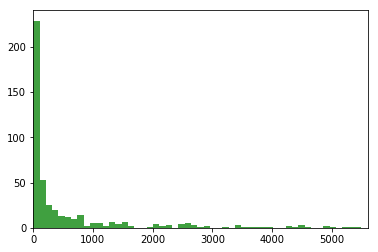

In [24]:
feature_descr(userID_count)

In [25]:
df_grouped_wourkout = df.groupby(['userID', 'workoutID'])
df_grouped_wourkout = df_grouped_wourkout.size()
df_grouped_wourkout.name = 'userID-workoutID count'

userID-workoutID count Summary:
count    11034.000000
mean        26.546130
std         21.903629
min          1.000000
25%         10.000000
50%         22.000000
75%         36.000000
max        345.000000
Name: userID-workoutID count, dtype: float64

Low occurrence for userID-workoutID count:
There are 261 unique values with 1 observation(s)
There are 314 unique values with 2 observation(s)
There are 430 unique values with 3 observation(s)
There are 302 unique values with 4 observation(s)
There are 236 unique values with 5 observation(s)
There are 302 unique values with 6 observation(s)
There are 172 unique values with 7 observation(s)
There are 228 unique values with 8 observation(s)
There are 323 unique values with 9 observation(s)

userID-workoutID count Histogram:


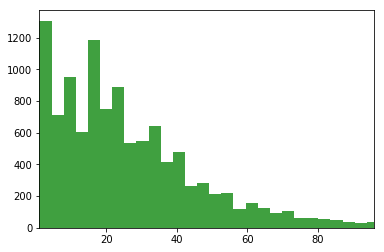

In [26]:
feature_descr(df_grouped_wourkout)

In [27]:
df_grouped_wourkout.loc[df_grouped_wourkout == max(df_grouped_wourkout)]

userID                    workoutID                           
5aa35456880e87b3f32ddf7c  c1d046a3-bf4e-4ba8-a43a-2568a3b21620    345
Name: userID-workoutID count, dtype: int64

In [28]:
# this is account used for S&S internal study
# we might need to exclude it (multiple people)
df_study = df.loc[df['userID'] == '5aa35456880e87b3f32ddf7c']
df_study.shape

(3506, 45)

In [29]:
df_grouped_wourkout.sort_values(ascending=False)[:10]

userID                    workoutID                           
5aa35456880e87b3f32ddf7c  c1d046a3-bf4e-4ba8-a43a-2568a3b21620    345
                          7464e24b-25af-4435-a29e-6735cf838dd4    305
                          870ca10a-1f71-4cbf-a3f8-6ef0f0cc56c1    281
                          21b51e5a-6a80-48d8-827b-b2309f4cd405    201
5a43c264fd4ef00da9b8ccce  3388ac48-1f31-46c1-88db-d82b72209a01    184
5a15b00e05cbc9b8ef26ac59  4d2ad298-337d-46bb-bd46-49f45d42158e    183
59debbdd05cbc9b8ef26ac1c  dbc82f2e-0401-43c6-9c9a-afc52434f724    176
5aa35456880e87b3f32ddf7c  908fe3e3-34c9-4c2f-8ae4-7d22354e2b9b    175
589d473d6ca711fcd8cb7af9  93a67da5-12c4-42d1-a067-ca77e04af8ab    174
5a43c264fd4ef00da9b8ccce  426232d3-7874-4c44-9a5a-6e9b860bbf1c    151
Name: userID-workoutID count, dtype: int64

## Grouping Dataset

In [30]:
grouping_vars = ['userID', 'exercise_clean']
# df_clean = df.loc[df['exercise_clean'].isin(["squat", "bench", "deadlift"])]
df_clean = df.assign(RepCount = df['RepCount']+1)
df_grouped = df_clean[ls_cont_features + grouping_vars].groupby(grouping_vars)

In [31]:
df_grouped_size = pd.DataFrame(df_grouped.size())
df_grouped_size.columns = ['TtlRepNum']
# df_grouped_size = df_grouped_size.reset_index(level = ['userID', 'exercise_clean'])
df_grouped_size.head(6)

TtlRepNum
userID                   exercise_clean           
589bcb116ca711fcd8cb7af3 bench                 188
                         deadlift              307
                         squat                 309
589c69d26ca711fcd8cb7af4 bench                  28
                         deadlift               15
                         squat                  51

In [32]:
df_grouped_count = df_grouped.count()
df_grouped_count = df_grouped_count.add_suffix('_count')
df_grouped_count.head(6)

rpe_num_count  RepCount_count  \
userID                   exercise_clean                                  
589bcb116ca711fcd8cb7af3 bench                       0             188   
                         deadlift                    0             307   
                         squat                       3             309   
589c69d26ca711fcd8cb7af4 bench                      18              28   
                         deadlift                    8              15   
                         squat                      26              51   

                                         weight_lbs_count  AvgVel_count  \
userID                   exercise_clean                                   
589bcb116ca711fcd8cb7af3 bench                        188           188   
                         deadlift                     307           307   
                         squat                        306           309   
589c69d26ca711fcd8cb7af4 bench                         28            28   
                         deadlift                      15            15   
                         squat                         51            51   

                                         ROM_count  PeakVel_count  \
userID                   exercise_clean                             
589bcb116ca711fcd8cb7af3 bench                 188            188   
                         deadlift              307            307   
                         squat                 309            309   
589c69d26ca711fcd8cb7af4 bench                  28             28   
                         deadlift               15             15   
                         squat                  51             51   

                                         PeakVelLoc_count  RepDur_count  \
userID                   exercise_clean                                   
589bcb116ca711fcd8cb7af3 bench                        188           188   
                         deadlift                     307           307   
                         squat                        309           309   
589c69d26ca711fcd8cb7af4 bench                         28            28   
                         deadlift                      15            15   
                         squat                         51            51   

                                         PeakAccel_count  
userID                   exercise_clean                   
589bcb116ca711fcd8cb7af3 bench                       124  
                         deadlift                    168  
                         squat                       178  
589c69d26ca711fcd8cb7af4 bench                         0  
                         deadlift                      0  
                         squat                         0

In [33]:
df_grouped_agg = df_grouped.agg([np.mean, np.min, np.max, np.std])
df_grouped_agg.columns = df_grouped_agg.columns.map('_'.join)
df_grouped_agg.shape

(1345, 36)

In [34]:
df_grouped_agg.head(6)

rpe_num_mean  rpe_num_amin  \
userID                   exercise_clean                               
589bcb116ca711fcd8cb7af3 bench                    NaN           NaN   
                         deadlift                 NaN           NaN   
                         squat               9.000000           9.0   
589c69d26ca711fcd8cb7af4 bench               7.916667           7.5   
                         deadlift            7.500000           6.0   
                         squat               7.903846           7.0   

                                         rpe_num_amax  rpe_num_std  \
userID                   exercise_clean                              
589bcb116ca711fcd8cb7af3 bench                    NaN          NaN   
                         deadlift                 NaN          NaN   
                         squat                    9.0     0.000000   
589c69d26ca711fcd8cb7af4 bench                    8.5     0.428746   
                         deadlift                 9.0     1.603567   
                         squat                    8.5     0.490290   

                                         RepCount_mean  RepCount_amin  \
userID                   exercise_clean                                 
589bcb116ca711fcd8cb7af3 bench                3.803191            1.0   
                         deadlift             3.742671            1.0   
                         squat                3.443366            1.0   
589c69d26ca711fcd8cb7af4 bench                4.321429            1.0   
                         deadlift             3.066667            1.0   
                         squat                3.450980            1.0   

                                         RepCount_amax  RepCount_std  \
userID                   exercise_clean                                
589bcb116ca711fcd8cb7af3 bench                     8.0      2.073152   
                         deadlift                 10.0      2.128757   
                         squat                     9.0      1.848357   
589c69d26ca711fcd8cb7af4 bench                    10.0      2.553916   
                         deadlift                  7.0      1.830951   
                         squat                    10.0      2.091064   

                                         weight_lbs_mean  weight_lbs_amin  \
userID                   exercise_clean                                     
589bcb116ca711fcd8cb7af3 bench                 64.819346          44.0924   
                         deadlift              92.098539          55.1155   
                         squat                 93.858454          44.0924   
589c69d26ca711fcd8cb7af4 bench                167.142857         135.0000   
                         deadlift             242.508200         154.3234   
                         squat                263.199353         154.3234   

                                         weight_lbs_amax  weight_lbs_std  \
userID                   exercise_clean                                    
589bcb116ca711fcd8cb7af3 bench                  82.67325       11.112841   
                         deadlift              121.25410       20.902514   
                         squat                 126.76565       28.334916   
589c69d26ca711fcd8cb7af4 bench                 185.00000       24.397502   
                         deadlift              374.78540       95.007174   
                         squat                 365.00000       58.769113   

                                         AvgVel_mean  AvgVel_amin  \
userID                   exercise_clean                             
589bcb116ca711fcd8cb7af3 bench              0.251339     0.097297   
                         deadlift           0.315348     0.169875   
                         squat              0.438289     0.196621   
589c69d26ca711fcd8cb7af4 bench              0.428938     0.130508   
                         deadlift           0.391967     0.055398   
                         squat          

In [35]:
# some checks
check = df.loc[df['userID'] == '589c69d26ca711fcd8cb7af4']
print(check.shape)
print(sum(np.isnan(check['PeakAccel'])))
check = df.loc[df['userID'] == '589bcb116ca711fcd8cb7af3']
print(check.shape)
print(sum(np.isnan(check['rpe_num'])))
check.loc[-np.isnan(check['rpe_num']),'AvgVel']

(94, 45)
94
(804, 45)
801


211318    1.017166
211319    1.249655
211320    1.392975
Name: AvgVel, dtype: float64

In [36]:
ls_categorical_features = ['setID', 'workoutID']
df_grouped_cat = df_clean[ls_categorical_features + grouping_vars].groupby(grouping_vars)
df_grouped_cat_count = df_grouped_cat.agg(pd.Series.nunique)
df_grouped_cat_count.columns = ['TtlSetNum', 'TtlWorkoutNum']
df_grouped_cat_count['AvgSetsPerWorkout'] = (df_grouped_cat_count['TtlSetNum']
                                   /df_grouped_cat_count['TtlWorkoutNum'])
df_grouped_cat_count.head(6)

TtlSetNum  TtlWorkoutNum  \
userID                   exercise_clean                             
589bcb116ca711fcd8cb7af3 bench                  30              6   
                         deadlift               51              9   
                         squat                  55             10   
589c69d26ca711fcd8cb7af4 bench                   4              1   
                         deadlift                4              1   
                         squat                  10              3   

                                         AvgSetsPerWorkout  
userID                   exercise_clean                     
589bcb116ca711fcd8cb7af3 bench                    5.000000  
                         deadlift                 5.666667  
                         squat                    5.500000  
589c69d26ca711fcd8cb7af4 bench                    4.000000  
                         deadlift                 4.000000  
                         squat                    3.333333

In [37]:
df_grouped_full = (df_grouped_size
                   .join(df_grouped_count)
                   .join(df_grouped_cat_count)
                   .join(df_grouped_agg)
                   .reset_index())
df_grouped_full['AvgRepsPerSet'] = (df_grouped_full['TtlRepNum']
                                    /df_grouped_full['TtlSetNum'])
print(df_grouped_full.shape)
df_grouped_full.head(6)

(1345, 52)


,userID,exercise_clean,TtlRepNum,rpe_num_count,RepCount_count,weight_lbs_count,AvgVel_count,ROM_count,PeakVel_count,PeakVelLoc_count,RepDur_count,PeakAccel_count,TtlSetNum,TtlWorkoutNum,AvgSetsPerWorkout,rpe_num_mean,rpe_num_amin,rpe_num_amax,rpe_num_std,RepCount_mean,RepCount_amin,RepCount_amax,RepCount_std,weight_lbs_mean,weight_lbs_amin,weight_lbs_amax,weight_lbs_std,AvgVel_mean,AvgVel_amin,AvgVel_amax,AvgVel_std,ROM_mean,ROM_amin,ROM_amax,ROM_std,PeakVel_mean,PeakVel_amin,PeakVel_amax,PeakVel_std,PeakVelLoc_mean,PeakVelLoc_amin,PeakVelLoc_amax,PeakVelLoc_std,RepDur_mean,RepDur_amin,RepDur_amax,RepDur_std,PeakAccel_mean,PeakAccel_amin,PeakAccel_amax,PeakAccel_std,AvgRepsPerSet
0,589bcb116ca711fcd8cb7af3,bench,188,0,188,188,188,188,188,188,188,124,30,6,5.000000,NaN,NaN,NaN,NaN,3.803191,1.0,8.0,2.073152,64.819346,44.0924,82.67325,11.112841,0.251339,0.097297,0.542807,0.090647,378.111702,220.0,505.0,43.474416,0.367724,0.151657,0.796367,0.126344,56.430851,21.0,98.0,24.118258,1.659464e+06,752777.0,3045166.0,498215.343038,2.776321,0.340337,11.17235,2.131513,6.266667
1,589bcb116ca711fcd8cb7af3,deadlift,307,0,307,307,307,307,307,307,307,168,51,9,5.666667,NaN,NaN,NaN,NaN,3.742671,1.0,10.0,2.128757,92.098539,55.1155,121.25410,20.902514,0.315348,0.169875,0.585430,0.083972,513.501629,437.0,589.0,21.429528,0.463412,0.248038,0.860429,0.125959,59.087948,13.0,84.0,13.658848,1.736786e+06,896759.0,2864807.0,425543.208407,4.969565,0.885919,16.56374,2.902424,6.019608
2,589bcb116ca711fcd8cb7af3,squat,309,3,309,306,309,309,309,309,309,178,55,10,5.500000,9.000000,9.0,9.0,0.000000,3.443366,1.0,9.0,1.848357,93.858454,44.0924,126.76565,28.334916,0.438289,0.196621,1.392975,0.125262,632.676375,184.0,780.0,58.014263,0.698799,0.273992,2.191936,0.194073,66.453074,13.0,95.0,23.917239,1.533132e+06,240478.0,2979737.0,364147.214625,10.496326,1.424811,75.33651,8.857351,5.618182
3,589c69d26ca711fcd8cb7af4,bench,28,18,28,28,28,28,28,28,28,0,4,1,4.000000,7.916667,7.5,8.5,0.428746,4.321429,1.0,10.0,2.553916,167.142857,135.0000,185.00000,24.397502,0.428938,0.130508,0.677655,0.154709,363.678571,185.0,415.0,49.404643,0.583057,0.330230,0.845773,0.156137,42.571429,13.0,73.0,19.176430,9.840567e+05,517517.0,2825347.0,486764.195374,NaN,NaN,NaN,NaN,7.000000
4,589c69d26ca711fcd8cb7af4,deadlift,15,8,15,15,15,15,15,15,15,0,4,1,4.000000,7.500000,6.0,9.0,1.603567,3.066667,1.0,7.0,1.830951,242.508200,154.3234,374.78540,95.007174,0.391967,0.055398,0.589924,0.167016,459.466667,155.0,505.0,85.200492,0.681842,0.069927,0.917366,0.257525,66.200000,60.0,91.0,7.570620,1.456683e+06,787750.0,2874725.0,732635.154544,NaN,NaN,NaN,NaN,3.750000
5,589c69d26ca711fcd8cb7af4,squat,51,26,51,51,51,51,51,51,51,0,10,3,3.333333,7.903846,7.0,8.5,0.490290,3.450980,1.0,10.0,2.091064,263.199353,154.3234,365.00000,58.769113,0.650233,0.466656,0.967707,0.144323,675.745098,614.0,737.0,22.817400,0.970015,0.716234,1.305449,0.152264,82.058824,24.0,90.0,10.765522,1.087100e+06,714294.0,1545684.0,220429.891757,NaN,NaN,NaN,NaN,5.100000


In [38]:
get_descr(df_grouped_full, list(df_grouped_full)[2:12])

,TtlRepNum,rpe_num_count,RepCount_count,weight_lbs_count,AvgVel_count,ROM_count,PeakVel_count,PeakVelLoc_count,RepDur_count,PeakAccel_count
count,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000
mean,217.776952,80.243866,217.776952,210.514498,217.762825,217.776952,217.776952,214.507807,214.507807,152.205948
std,440.574869,286.084297,440.574869,431.231713,440.561914,440.574869,440.574869,439.629538,439.629538,347.649368
min,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,18.000000,16.000000,18.000000,18.000000,18.000000,16.000000,16.000000,0.000000
50%,55.000000,2.000000,55.000000,52.000000,55.000000,55.000000,55.000000,52.000000,52.000000,20.000000
75%,198.000000,35.000000,198.000000,192.000000,198.000000,198.000000,198.000000,194.000000,194.000000,107.000000
max,5451.000000,5386.000000,5451.000000,5427.000000,5451.000000,5451.000000,5451.000000,5451.000000,5451.000000,3034.000000
pct_missing,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pct_zeros,0.000000,48.401487,0.000000,2.602230,0.000000,0.000000,0.000000,1.635688,1.635688,32.490706


In [39]:
get_descr(df_grouped_full, list(df_grouped_full)[12:23])

,TtlSetNum,TtlWorkoutNum,AvgSetsPerWorkout,rpe_num_mean,rpe_num_amin,rpe_num_amax,rpe_num_std,RepCount_mean,RepCount_amin,RepCount_amax,RepCount_std
count,1345.000000,1345.000000,1345.000000,694.000000,694.000000,694.000000,677.000000,1345.000000,1345.000000,1345.000000,1327.000000
mean,54.677323,10.940520,4.236676,7.537121,6.628170,8.694020,0.635031,3.586152,1.031227,10.062454,2.269820
std,110.240167,20.051482,2.722200,0.985679,1.200416,1.219525,0.457355,2.680608,0.304589,9.094279,2.066525
min,1.000000,1.000000,1.000000,5.500000,5.500000,5.500000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,1.000000,2.000000,6.957754,5.500000,8.000000,0.246296,2.408955,1.000000,5.000000,1.310211
50%,14.000000,3.000000,4.000000,7.481395,6.000000,9.000000,0.676697,3.077088,1.000000,8.000000,1.785060
75%,49.000000,11.000000,5.636364,8.113539,7.000000,10.000000,0.961562,4.000000,1.000000,12.000000,2.512231
max,1086.000000,264.000000,29.000000,10.000000,10.000000,10.000000,2.003481,55.965517,10.000000,115.000000,25.412345
pct_missing,0.000000,0.000000,0.000000,48.400000,48.400000,48.400000,49.670000,0.000000,0.000000,0.000000,1.340000
pct_zeros,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.152416,0.000000,0.000000,0.000000,0.817844


In [40]:
get_descr(df_grouped_full, list(df_grouped_full)[23:35])

,weight_lbs_mean,weight_lbs_amin,weight_lbs_amax,weight_lbs_std,AvgVel_mean,AvgVel_amin,AvgVel_amax,AvgVel_std,ROM_mean,ROM_amin,ROM_amax,ROM_std
count,1310.000000,1310.000000,1310.000000,1291.000000,1345.000000,1345.000000,1345.000000,1327.000000,1345.000000,1345.000000,1345.000000,1327.000000
mean,255.729774,173.395272,363.533489,47.397950,0.527477,0.276914,0.873761,0.131612,479.799288,332.858736,655.686245,55.502884
std,110.549779,116.032241,188.408381,44.215399,0.249643,0.238548,0.410232,0.082903,144.790138,168.673918,253.772210,48.882415
min,2.666667,0.000000,4.409240,0.000000,0.134820,0.000000,0.134820,0.000000,177.000000,0.000000,177.000000,0.000000
25%,176.674699,95.000000,230.000000,14.649850,0.369528,0.135515,0.591473,0.073514,354.885542,179.000000,472.000000,22.903019
50%,236.996650,143.300300,319.669900,39.228161,0.486694,0.209384,0.820000,0.114624,484.833333,285.000000,622.000000,38.781989
75%,320.000000,225.000000,451.947100,68.005108,0.625617,0.333824,1.056207,0.172042,594.535608,467.000000,761.000000,71.012706
max,1000.000000,1000.000000,1000.000000,411.358031,2.766234,2.758770,2.960175,0.723169,1298.333333,1250.000000,1761.000000,404.579603
pct_missing,2.600000,2.600000,2.600000,4.010000,0.000000,0.000000,0.000000,1.340000,0.000000,0.000000,0.000000,1.340000
pct_zeros,0.000000,0.892193,0.000000,14.052045,0.000000,0.297398,0.000000,0.074349,0.000000,0.297398,0.000000,0.148699


In [41]:
get_descr(df_grouped_full, list(df_grouped_full)[35:47])

,PeakVel_mean,PeakVel_amin,PeakVel_amax,PeakVel_std,PeakVelLoc_mean,PeakVelLoc_amin,PeakVelLoc_amax,PeakVelLoc_std,RepDur_mean,RepDur_amin,RepDur_amax,RepDur_std
count,1345.000000,1345.000000,1345.000000,1327.000000,1323.000000,1323.000000,1323.000000,1305.000000,1.323000e+03,1.323000e+03,1.323000e+03,1.305000e+03
mean,0.866957,0.487316,1.428509,0.204361,70.070302,39.124717,87.879819,12.210481,1.085650e+06,6.198589e+05,2.230390e+06,3.089393e+05
std,0.456346,0.428969,0.728821,0.146211,13.946220,23.434500,10.864726,8.301399,3.699706e+05,3.202784e+05,1.085670e+06,1.816335e+05
min,0.212000,0.000000,0.250000,0.000000,14.750000,0.000000,18.000000,0.000000,1.741738e+05,0.000000e+00,2.207030e+05,3.711603e+03
25%,0.576314,0.230000,0.927329,0.103655,63.306985,18.000000,85.000000,5.597619,8.252993e+05,3.951420e+05,1.465348e+06,1.846040e+05
50%,0.795830,0.372686,1.311776,0.173892,72.372423,35.000000,91.000000,9.861034,1.059716e+06,5.757140e+05,2.102326e+06,2.921016e+05
75%,1.038617,0.614398,1.720857,0.264290,80.717517,58.000000,95.000000,17.610310,1.299357e+06,7.902070e+05,2.849319e+06,4.075740e+05
max,5.135615,4.941818,5.560000,1.195050,93.000000,93.000000,99.000000,47.376154,2.689115e+06,2.289306e+06,1.129953e+07,1.441311e+06
pct_missing,0.000000,0.000000,0.000000,1.340000,1.640000,1.640000,1.640000,2.970000,1.640000e+00,1.640000e+00,1.640000e+00,2.970000e+00
pct_zeros,0.000000,0.297398,0.000000,0.074349,0.000000,1.710037,0.000000,0.074349,0.000000e+00,1.189591e+00,0.000000e+00,0.000000e+00


In [42]:
get_descr(df_grouped_full, list(df_grouped_full)[47:])

,PeakAccel_mean,PeakAccel_amin,PeakAccel_amax,PeakAccel_std,AvgRepsPerSet
count,908.000000,908.000000,908.000000,898.000000,1345.000000
mean,25.280972,5.800550,193.522793,32.747513,4.689937
std,56.629355,34.653664,365.340936,66.430703,4.147811
min,0.541882,0.000000,0.928244,0.015363,1.000000
25%,6.676204,0.745806,28.708400,5.498875,3.000000
50%,11.334591,1.680258,60.131768,10.783006,4.000000
75%,23.052719,3.546686,153.123075,22.934381,5.222222
max,978.860420,775.705440,2686.953000,714.116555,87.000000
pct_missing,32.490000,32.490000,32.490000,33.230000,0.000000
pct_zeros,0.000000,2.304833,0.000000,0.000000,0.000000


## Train vs. Test

In [43]:
df_train = (df_grouped_full.loc[df_grouped_full['exercise_clean']
                                .isin(["squat", "bench", "deadlift"])])
df_test = (df_grouped_full.loc[df_grouped_full['exercise_clean']
                               .isin(["squat other", "bench other", "deadlift other"])])
print(df_train.shape)
print(df_test.shape)

(881, 52)
(464, 52)


In [44]:
print(get_label_distribution(df_train['exercise_clean']))
print(get_label_distribution(df_test['exercise_clean']))

   Exercise  Row count
0     bench        323
1  deadlift        247
2     squat        311
         Exercise  Row count
0     bench other        169
1  deadlift other         82
2     squat other        213


In [518]:
check_frequency(df_train['userID'])
check_frequency(df_test['userID'])


userID has 420 unique values
Top 10 values are:
59d2d5ec85ea1c6b42e4b2a2    3
59c65dd585ea1c6b42e4b281    3
59b55d6185ea1c6b42e4b20e    3
59beead685ea1c6b42e4b24f    3
59c652a285ea1c6b42e4b280    3
5a6b43e6880e87b3f32ddf27    3
58a501cf6ca711fcd8cb7b22    3
58ac03026ca711fcd8cb7b37    3
59bb092785ea1c6b42e4b234    3
59bfc20a85ea1c6b42e4b256    3
Name: userID, dtype: int64

userID has 263 unique values
Top 10 values are:
59c0b6e285ea1c6b42e4b261    3
59b5a0ee85ea1c6b42e4b213    3
58dda17a6ca711fcd8cb7b5b    3
58a293066ca711fcd8cb7b14    3
59810a5585ea1c6b42e4b1c7    3
58a2b04d6ca711fcd8cb7b15    3
59ab297785ea1c6b42e4b1d7    3
58e916ca6ca711fcd8cb7b63    3
59bc155785ea1c6b42e4b23d    3
589d473d6ca711fcd8cb7af9    3
Name: userID, dtype: int64


## Preparing Data for Analysis

In [210]:
exercises = ['bench', 'deadlift', 'squat']

In [564]:
def impute_data(data_fit, data_transform):
    """
    Args:
        data_fit: feature dataset used to fit standardization
        data_transform: feature dataset to apply standardization to
    
    Returns:
    """
    
    imputer = preprocessing.Imputer(strategy='mean').fit(data_fit)
    data_im = imputer.transform(data_transform)
    
    print(f"Dataset mean before impute: {round(data_fit.mean().mean(),2)}")
    print(f"Number of missing values: {data_fit.isnull().sum().sum()}")
    print(f"Dataset mean after impute: {round(data_im.mean(),2)}")
    print(f"Number of missing after impute: {np.isnan(data_im).sum()}")
    
    return data_im

def standardize_data(data_fit, data_transform):
    """
    Standardize input dataset and apply it to the second input dataset
    
    Args:
        data_fit: feature dataset used to fit standardization
        data_transform: feature dataset to apply standardization to
    
    Returns:
        standardized dataset
    """
    
    scaler = preprocessing.RobustScaler().fit(data_fit)
#     scaler = preprocessing.StandardScaler().fit(data_fit)
    data_std = scaler.transform(data_transform)
    print(f"\nMeans of standardized features:\n {np.around(np.mean(data_std, axis = 0),2)}")
    print(f"STDV of standardized features:\n {np.around(np.std(data_std, axis = 0),2)}")
    
    return data_std

def prep_data(data_in, features, std = True):
  
    data_in = data_in[features+grouping_vars]
    data_out = pd.DataFrame(columns=features)
    data_ids = pd.DataFrame(columns=grouping_vars)
    
    ex_counts = []
    for ex in exercises:
        print("="*80)
        print(f"Preparing data for {ex}:\n")
        data = (data_in.loc[data_in['exercise_clean']==ex]
              .drop(grouping_vars, axis = 1))
        ids = (data_in.loc[data_in['exercise_clean']==ex]
              .drop(features, axis = 1))        
        ex_counts.append(data.shape[0])
        data = impute_data(data, data)
        if std:
            data = standardize_data(data, data)  
        print(f"Transformed dataset shape: {data.shape}")
        data_out = np.concatenate((data_out, data), axis = 0)
        data_ids = np.concatenate((data_ids, ids), axis = 0)
        
    data_out, data_ids = pd.DataFrame(data_out), pd.DataFrame(data_ids)
    data_out.columns, data_ids.columns = features, grouping_vars
        
    data_out = data_out.join(data_ids)
    
    return data_out

In [565]:
df_train_pr = prep_data(df_train, list(df_train)[2:])

Preparing data for bench:

Dataset mean before impute: 81814.91
Number of missing values: 1110
Dataset mean after impute: 81814.91
Number of missing after impute: 0

Means of standardized features:
 [ 1.05  2.56  1.05  1.02  1.05  1.05  1.05  1.06  1.06  1.11  1.12  0.78
  0.08 -0.   -0.    0.    0.    0.17  0.01  0.29  0.29  0.07 -0.01  0.21
  0.16  0.18  0.54  0.11  0.16  0.13  0.2   0.23  0.42  0.25  0.41  0.09
  0.19 -0.11  0.61 -0.64 -0.01  0.01  0.15  0.05  0.   -0.    0.62  0.06
  0.    0.21]
STDV of standardized features:
 [ 2.67  9.05  2.67  2.64  2.67  2.67  2.67  2.71  2.71  2.87  2.88  2.16
  0.83  3.73  1.38  1.62  4.87  1.16  0.1   1.19  1.59  0.82  0.73  1.16
  0.89  0.9   1.66  0.78  0.76  1.02  0.86  0.61  1.25  1.06  1.64  0.74
  0.78  0.7   1.55  1.84  0.78  0.71  0.79  0.72  0.81  2.78  4.74  1.86
  1.95  1.27]
Transformed dataset shape: (323, 50)
Preparing data for deadlift:

Dataset mean before impute: 92584.84
Number of missing values: 866
Dataset mean after impu

In [566]:
df_train_pr.head(5)

,TtlRepNum,rpe_num_count,RepCount_count,weight_lbs_count,AvgVel_count,ROM_count,PeakVel_count,PeakVelLoc_count,RepDur_count,PeakAccel_count,TtlSetNum,TtlWorkoutNum,AvgSetsPerWorkout,rpe_num_mean,rpe_num_amin,rpe_num_amax,rpe_num_std,RepCount_mean,RepCount_amin,RepCount_amax,RepCount_std,weight_lbs_mean,weight_lbs_amin,weight_lbs_amax,weight_lbs_std,AvgVel_mean,AvgVel_amin,AvgVel_amax,AvgVel_std,ROM_mean,ROM_amin,ROM_amax,ROM_std,PeakVel_mean,PeakVel_amin,PeakVel_amax,PeakVel_std,PeakVelLoc_mean,PeakVelLoc_amin,PeakVelLoc_amax,PeakVelLoc_std,RepDur_mean,RepDur_amin,RepDur_amax,RepDur_std,PeakAccel_mean,PeakAccel_amin,PeakAccel_amax,PeakAccel_std,AvgRepsPerSet,userID,exercise_clean
0,0.568182,-0.047619,0.568182,0.581236,0.568182,0.568182,0.568182,0.588506,0.588506,0.571429,0.28866,0.166667,0.181818,0,0,0,0,0.263466,0,-0.125,0.0101304,-1.46996,-0.803179,-1.42446,-0.473182,-0.673142,-0.380741,-0.486526,-0.27958,0.511689,0.0414938,0.13172,0.269017,-0.635334,-0.513321,-0.452761,-0.23415,-0.38864,0.25,0.571429,0.540057,1.88524,1.05048,0.529269,0.752042,-1.38851,-0.448198,-1.39871,-1.53681,0.905709,589bcb116ca711fcd8cb7af3,bench
1,-0.159091,0.380952,-0.159091,-0.15103,-0.159091,-0.159091,-0.159091,-0.147126,-0.147126,-0.182371,-0.247423,-0.25,-0.103896,1.25856,1.33983,-0.970674,-4.25595,0.570021,0,0.125,0.389948,-0.316335,0,-0.623057,-0.171615,0.0429637,-0.10692,-0.227018,0.300681,0.353811,-0.248963,-0.110215,0.445431,-0.000744192,0.354553,-0.397123,-0.0711353,-1.00018,-0.416667,-3,0.0672703,0.159015,0.266612,0.3798,0.698039,0,0.617235,0.0598225,0,1.23134,589c69d26ca711fcd8cb7af4,bench
2,-0.0772727,0.952381,-0.0772727,-0.0686499,-0.0772727,-0.0772727,-0.0772727,-0.0643678,-0.0643678,-0.182371,-0.0824742,-0.166667,0.467532,-5.33735,-1.77994,-0.970674,0.908452,-0.391682,0,-0.375,-0.499706,0.457283,-0.618458,0.277604,0.585151,0.281196,0.401514,0.657111,0.823177,-0.27616,0.406639,-0.258065,-0.453813,0.215296,0.420415,0.587125,0.886746,-0.26089,-0.166667,-0.285714,1.21284,-0.507296,-0.558443,-0.487871,-0.312208,0,0.617235,0.0598225,0,-0.174787,589cef4a6ca711fcd8cb7af6,bench
3,-0.159091,0.452381,-0.159091,-0.15103,-0.159091,-0.159091,-0.159091,-0.147126,-0.147126,-0.182371,-0.103093,0.166667,-0.722944,4.03919,2.11978,1,-2.72158,0.443264,0,0.375,1.12031,0.229318,0.560285,-0.0431656,-0.353457,-0.51377,-0.193556,0.701237,0.551841,-0.0829509,0.456432,0.768817,1.53794,-0.509835,-0.103604,0.891438,0.802958,-1.17983,-0.333333,-2,0.285794,0.906685,0.672529,0.281256,0.572232,0,0.617235,0.0598225,0,-0.746656,589d0cf46ca711fcd8cb7af7,bench
4,11.6955,13.2857,11.6955,11.7849,11.6955,11.6955,11.6955,11.8437,11.8437,0.772036,11.3608,9.33333,0.149798,3.20985,-1.77994,1.98534,3.48375,0.387066,0,1.125,0.536909,-0.0392455,-0.705788,1.46763,0.00893982,-0.509159,-0.688246,1.21492,-0.0593529,-0.675688,-0.539419,0.989247,0.417691,-0.368713,-0.715777,1.42864,0.177645,0.575453,-0.416667,0.714286,-0.108414,0.276215,-0.931007,1.64666,0.187025,-1.3017,-0.398203,-0.894528,-1.06716,0.187415,589d473d6ca711fcd8cb7af9,bench


In [569]:
df_train_pr = prep_data(df_train, list(df_train)[2:])

Preparing data for bench:

Dataset mean before impute: 81814.91
Number of missing values: 1110
Dataset mean after impute: 81814.91
Number of missing after impute: 0

Means of standardized features:
 [ 1.05  2.56  1.05  1.02  1.05  1.05  1.05  1.06  1.06  1.11  1.12  0.78
  0.08 -0.   -0.    0.    0.    0.17  0.01  0.29  0.29  0.07 -0.01  0.21
  0.16  0.18  0.54  0.11  0.16  0.13  0.2   0.23  0.42  0.25  0.41  0.09
  0.19 -0.11  0.61 -0.64 -0.01  0.01  0.15  0.05  0.   -0.    0.62  0.06
  0.    0.21]
STDV of standardized features:
 [ 2.67  9.05  2.67  2.64  2.67  2.67  2.67  2.71  2.71  2.87  2.88  2.16
  0.83  3.73  1.38  1.62  4.87  1.16  0.1   1.19  1.59  0.82  0.73  1.16
  0.89  0.9   1.66  0.78  0.76  1.02  0.86  0.61  1.25  1.06  1.64  0.74
  0.78  0.7   1.55  1.84  0.78  0.71  0.79  0.72  0.81  2.78  4.74  1.86
  1.95  1.27]
Transformed dataset shape: (323, 50)
Preparing data for deadlift:

Dataset mean before impute: 92584.84
Number of missing values: 866
Dataset mean after impu

In [570]:
print(df_train_pr.shape)
get_label_distribution(df_train_pr['exercise_clean'])

(881, 52)


,Exercise,Row count
0,bench,323
1,deadlift,247
2,squat,311


In [571]:
features_to_plot = ['weight_lbs_mean', 'AvgVel_mean', 'PeakVelLoc_mean',
                    'ROM_mean', 'PeakVel_mean', 'RepDur_mean',
                   'AvgVel_std', 'PeakVel_std', ]

df_train_pr = prep_data(df_train, features_to_plot, std=True)

Preparing data for bench:

Dataset mean before impute: 115766.88
Number of missing values: 21
Dataset mean after impute: 115766.88
Number of missing after impute: 0

Means of standardized features:
 [ 0.07  0.18 -0.11  0.13  0.25  0.01  0.16  0.19]
STDV of standardized features:
 [ 0.82  0.9   0.7   1.02  1.06  0.71  0.76  0.78]
Transformed dataset shape: (323, 8)
Preparing data for deadlift:

Dataset mean before impute: 155997.7
Number of missing values: 26
Dataset mean after impute: 155997.7
Number of missing after impute: 0

Means of standardized features:
 [ 0.02  0.24 -0.1  -0.06  0.23  0.07  0.21  0.17]
STDV of standardized features:
 [ 0.76  1.16  1.03  0.92  1.19  0.8   0.97  0.95]
Transformed dataset shape: (247, 8)
Preparing data for squat:

Dataset mean before impute: 147570.14
Number of missing values: 23
Dataset mean after impute: 147570.14
Number of missing after impute: 0

Means of standardized features:
 [ 0.06  0.19 -0.25 -0.06  0.22 -0.    0.14  0.19]
STDV of standard

In [572]:
print(df_train_pr.shape)
get_label_distribution(df_train_pr['exercise_clean'])

(881, 10)


,Exercise,Row count
0,bench,323
1,deadlift,247
2,squat,311


In [573]:
get_descr(df_train_pr, features_to_plot)

,weight_lbs_mean,AvgVel_mean,PeakVelLoc_mean,ROM_mean,PeakVel_mean,RepDur_mean,AvgVel_std,PeakVel_std
count,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000
unique,824.000000,879.000000,852.000000,876.000000,879.000000,869.000000,872.000000,872.000000
top,0.055870,0.000000,-0.246161,0.000000,0.000000,0.000000,0.214312,0.171850
freq,11.000000,3.000000,5.000000,3.000000,3.000000,7.000000,7.000000,7.000000
pct_missing,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pct_zeros,0.340522,0.340522,0.340522,0.340522,0.340522,0.794552,0.340522,0.340522


## Visualize the Data

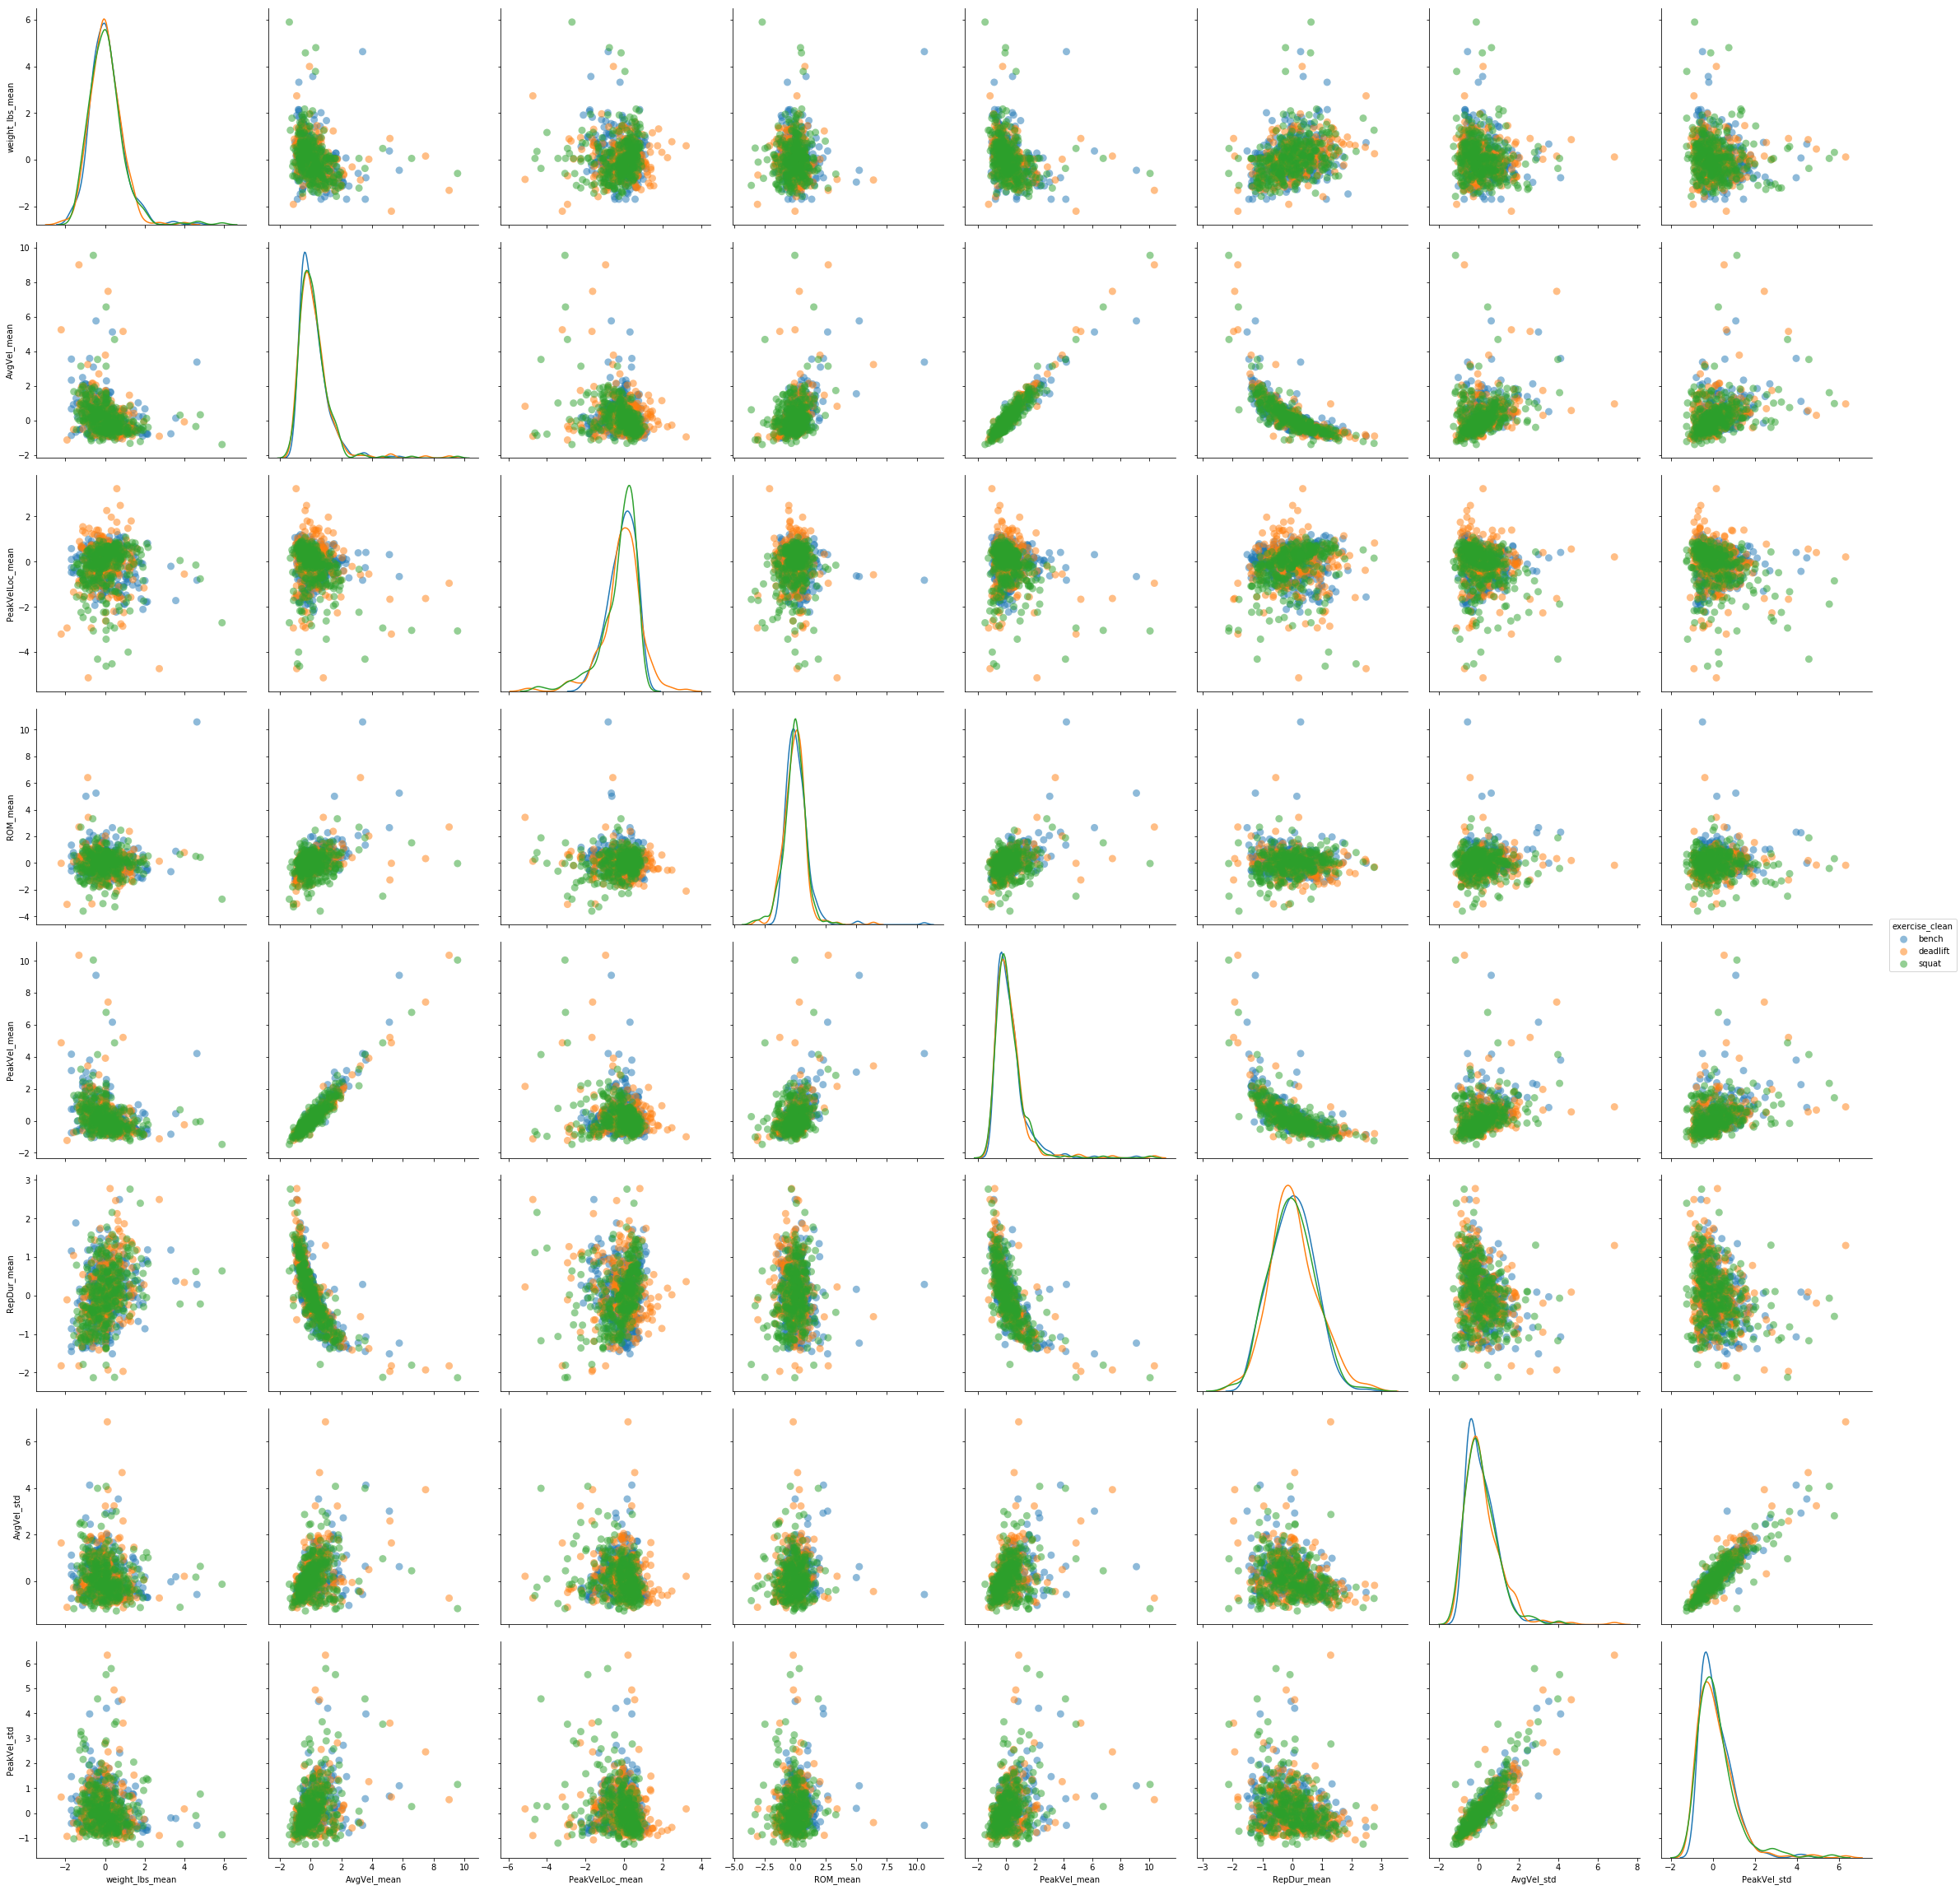

In [574]:
# https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
sns.pairplot(df_train_pr, hue='exercise_clean', diag_kind = 'kde',
            plot_kws = {'alpha': 0.5, 's': 80, 'edgecolor': 'none'},
            size = 4)

In [377]:
def plot_exercise_grid(data, exercise, features_to_include):
    
    grid = sns.PairGrid(data= data[data['exercise_clean'] == exercise],
                        vars = features_to_include, size = 4)
    # Map a scatter plot to the upper triangle
    grid = grid.map_upper(plt.scatter, cmap='cool_d')
    # Map a histogram to the diagonal
    grid = grid.map_diag(plt.hist)
    # Map a density plot to the lower triangle
    # This gives a lot of innocuous warnings if warnings are not disabled
    grid = grid.map_lower(sns.kdeplot, shade=True, shade_lowest=False)    

/home/yulia/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


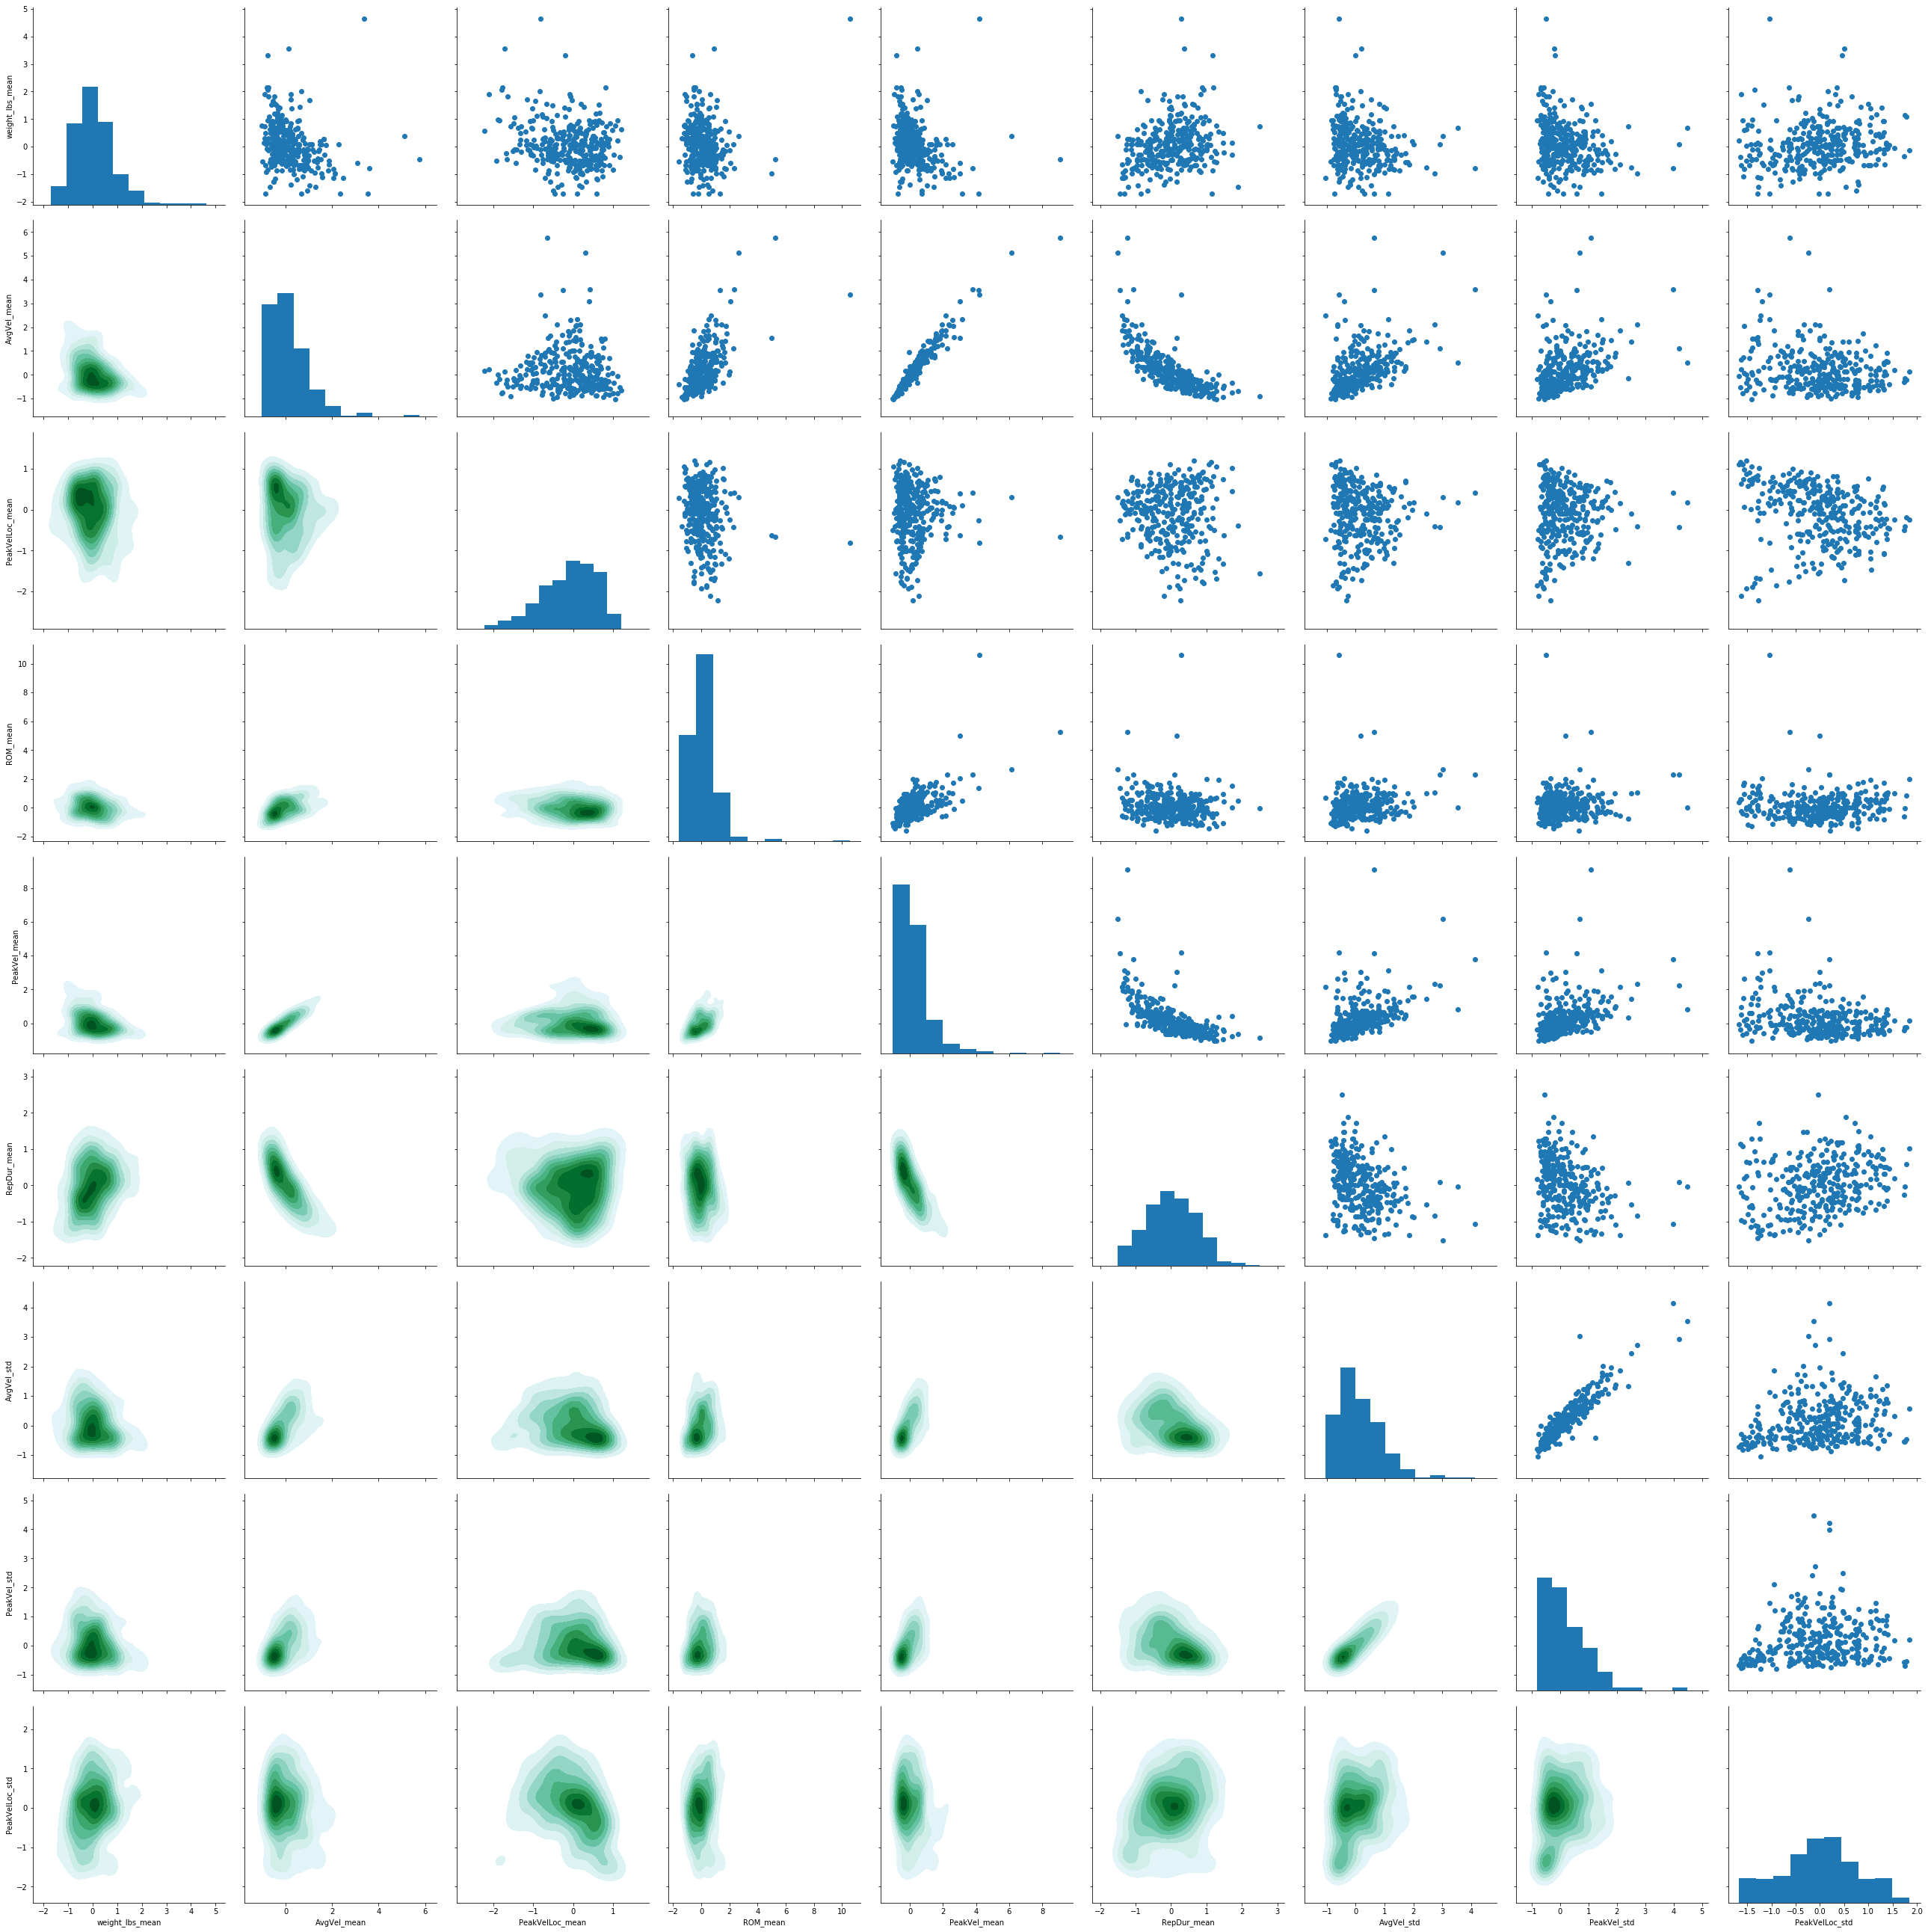

In [384]:
plot_exercise_grid(df_train_pr, 'bench', list(df_train_pr)[:-1])

/home/yulia/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


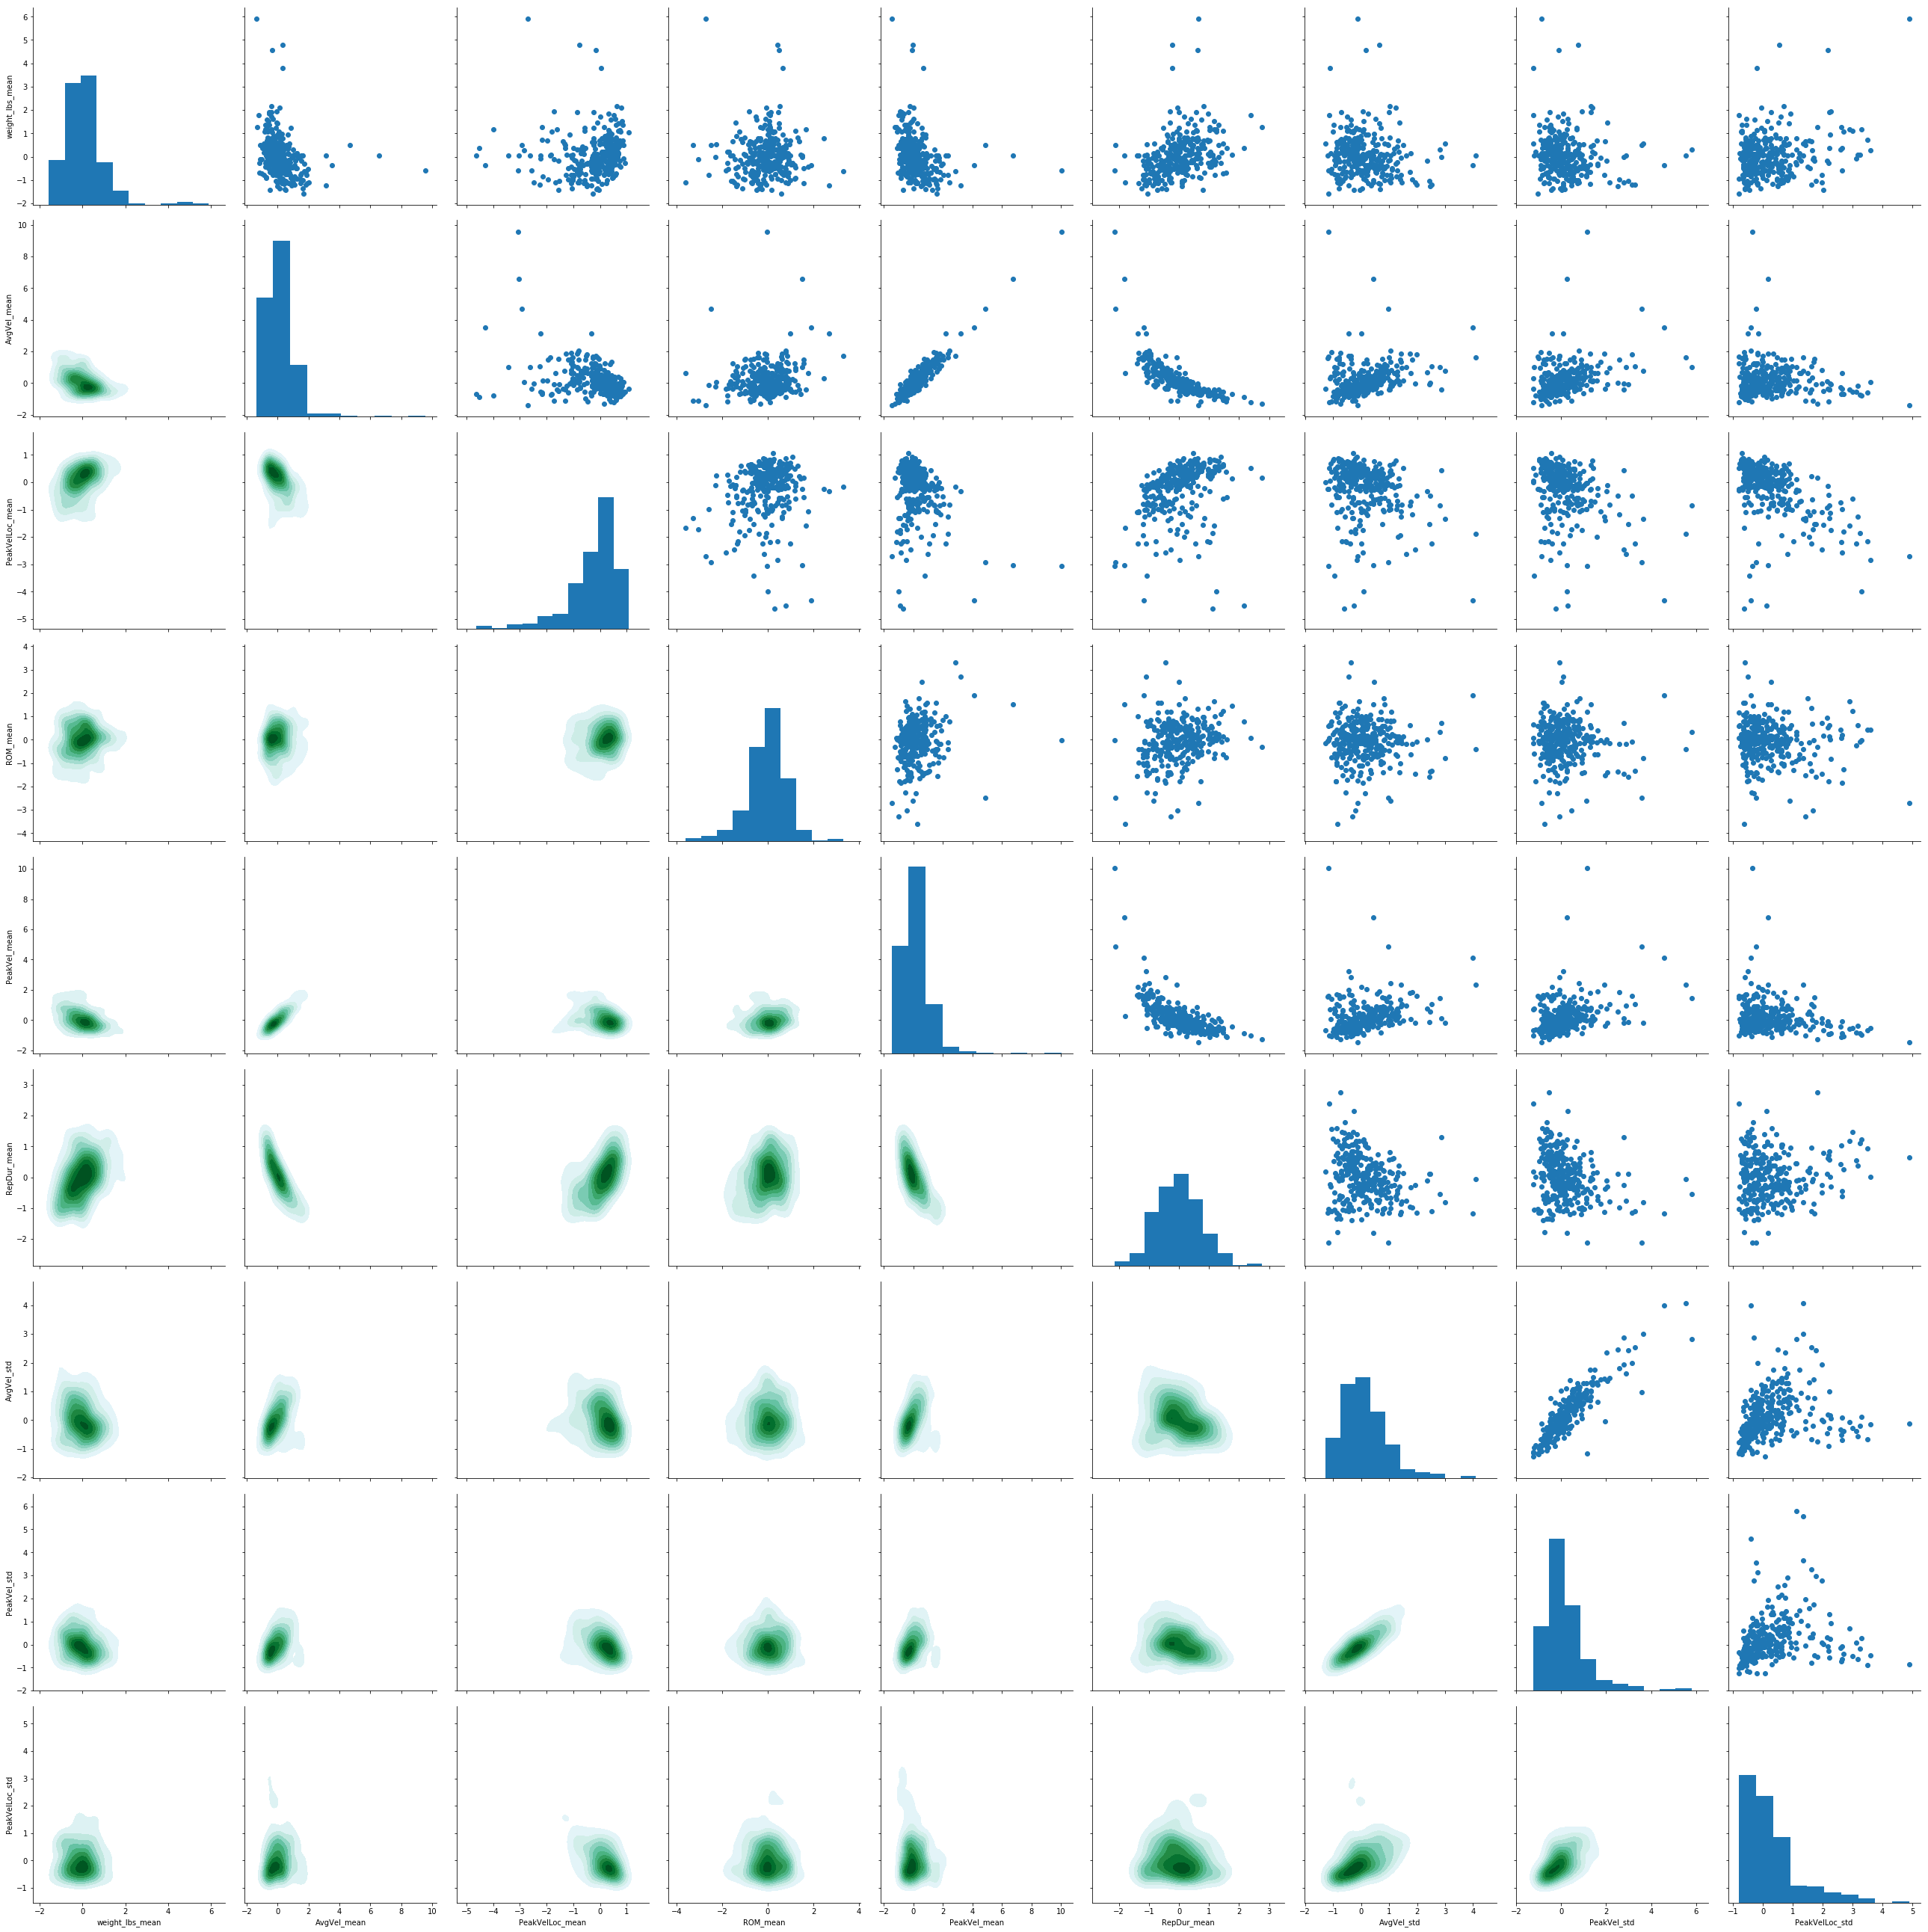

In [385]:
plot_exercise_grid(df_train_pr, 'squat', list(df_train_pr)[:-1])

/home/yulia/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


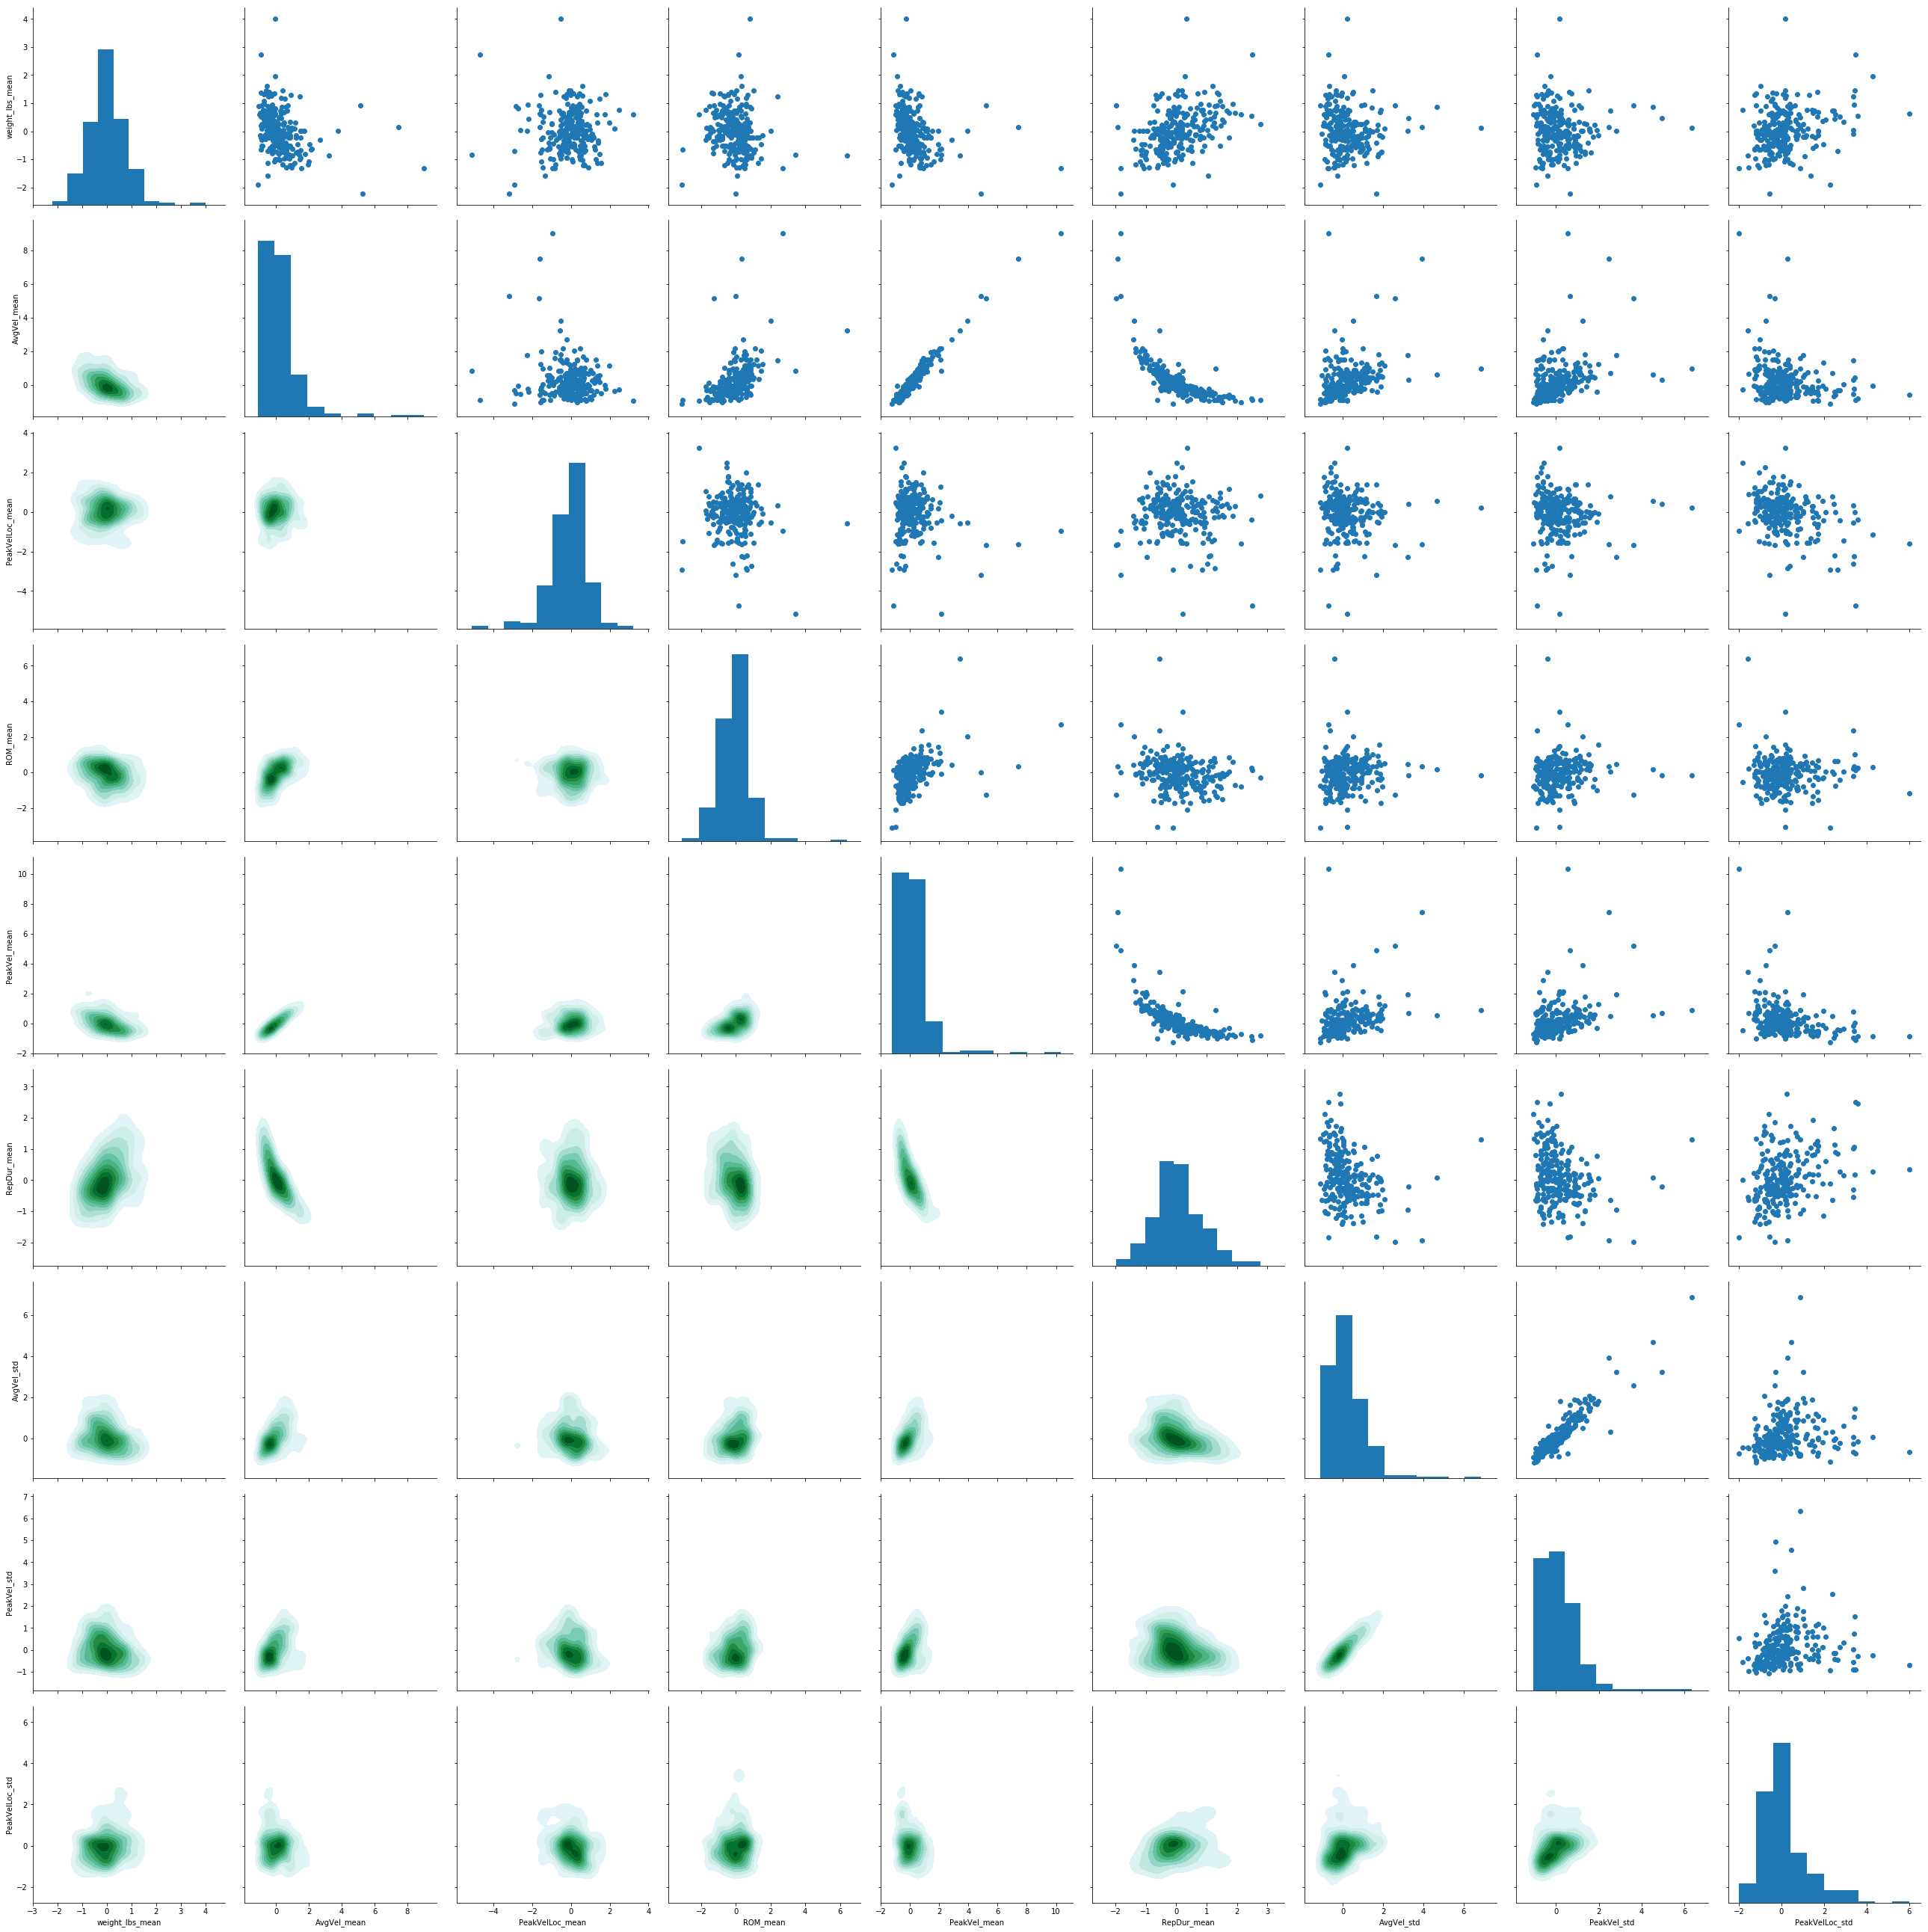

In [386]:
plot_exercise_grid(df_train_pr, 'deadlift', list(df_train_pr)[:-1])

## Hierarchical Clustering

All credit goes to:
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [596]:
check_frequency(df_train_pr["exercise_clean"])


exercise_clean has 3 unique values
Top 10 values are:
bench       323
squat       311
deadlift    247
Name: exercise_clean, dtype: int64


Clustering for bench
Clustering dataset shape: (323, 8)


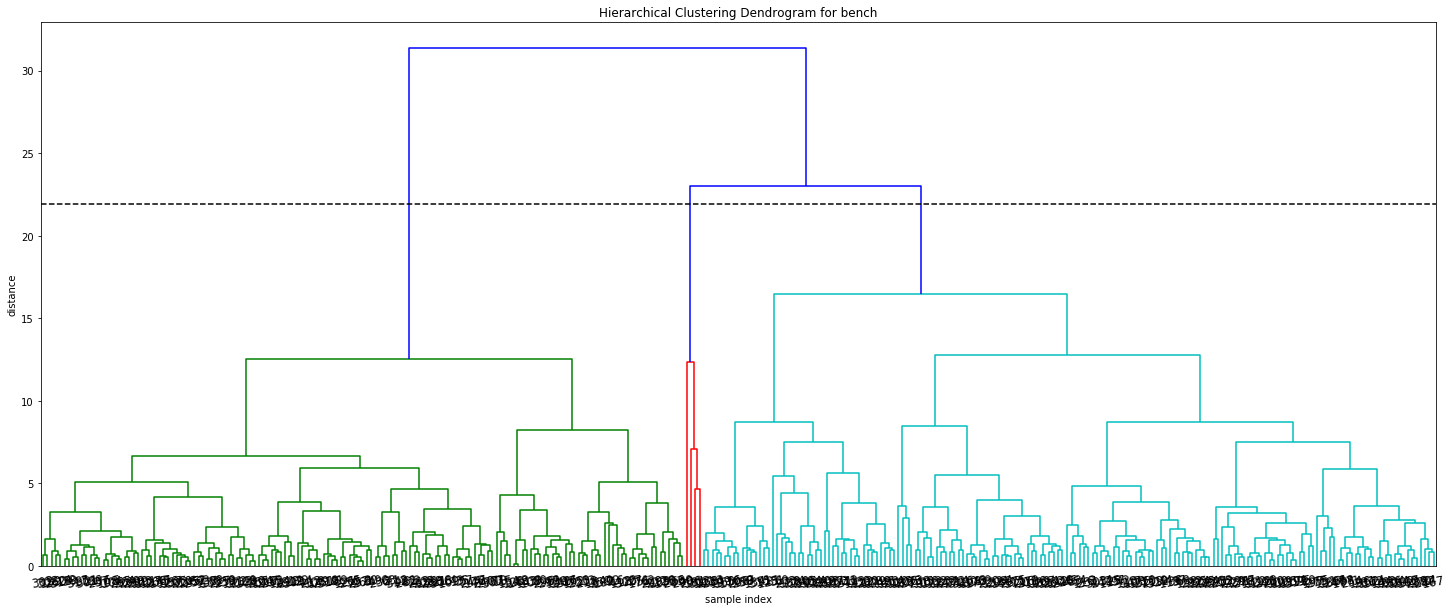


Cluster has 3 unique values
Top 10 values are:
3    170
1    149
2      4
Name: Cluster, dtype: int64
Clustering for squat
Clustering dataset shape: (311, 8)


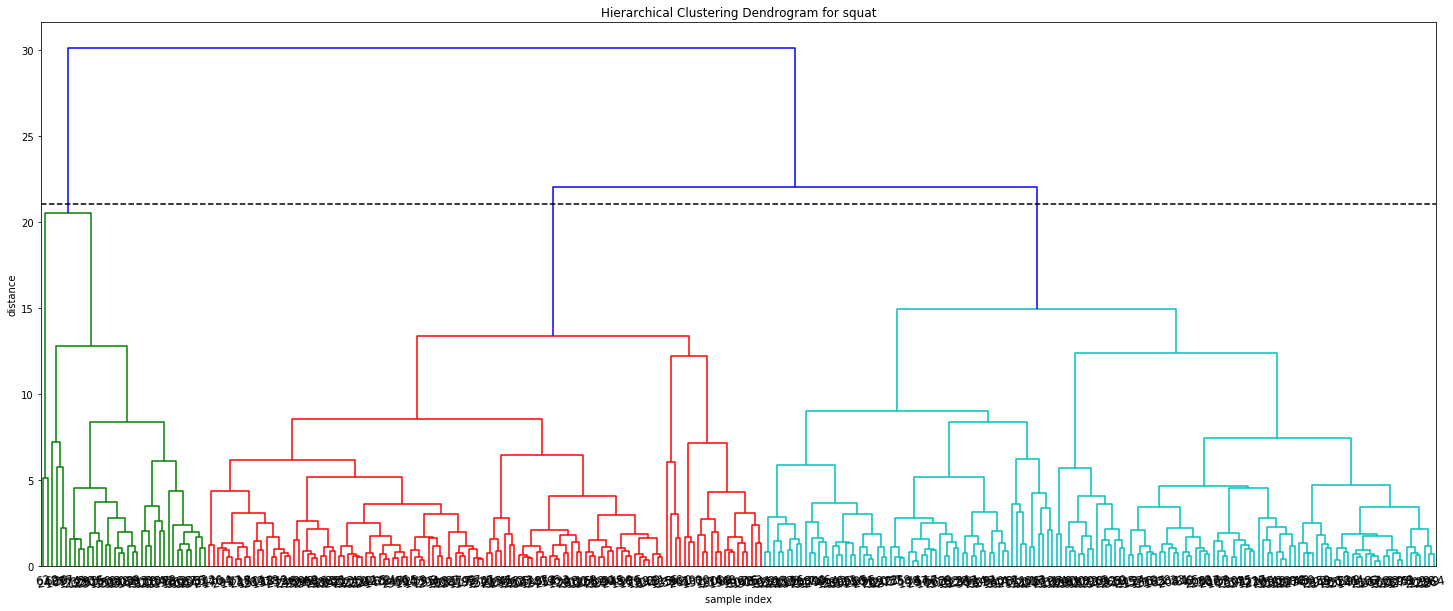


Cluster has 3 unique values
Top 10 values are:
3    150
2    124
1     37
Name: Cluster, dtype: int64
Clustering for deadlift
Clustering dataset shape: (247, 8)


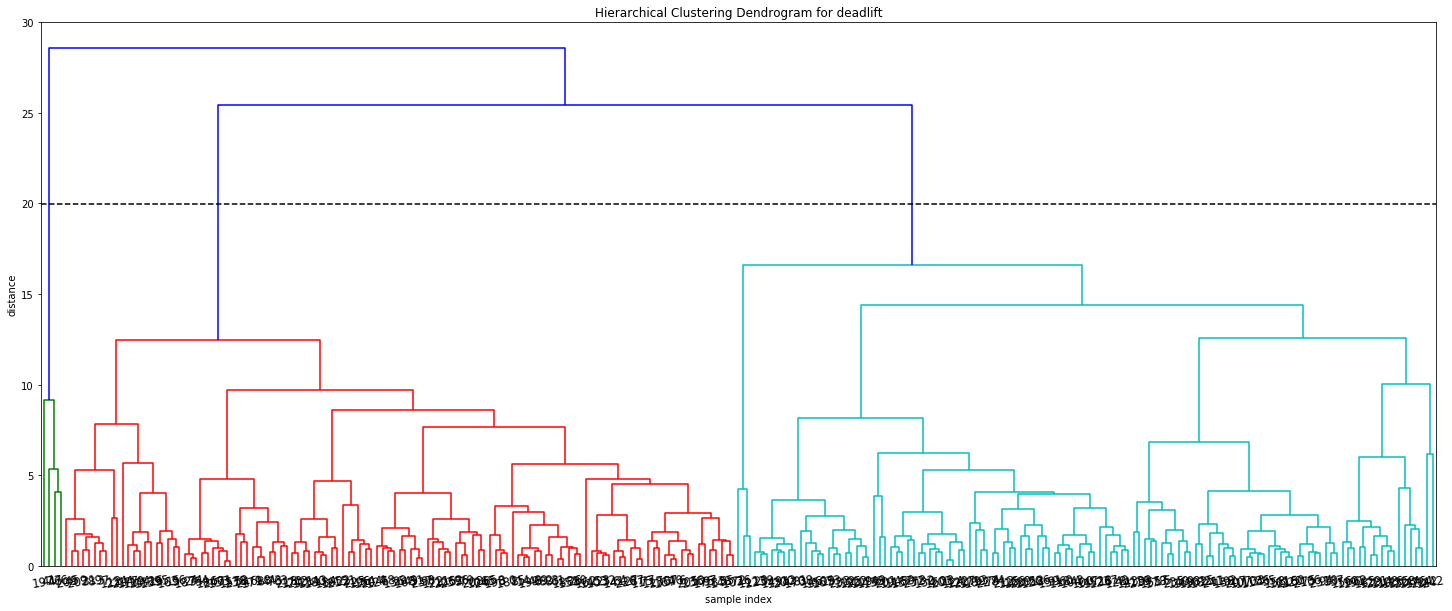


Cluster has 3 unique values
Top 10 values are:
3    124
2    119
1      4
Name: Cluster, dtype: int64


In [678]:
def make_clusters(data, exercise, features, cutoff, link='ward', dist='euclidean'):
    
    print("="*150)
    print(f"Clustering for {exercise}")
    IDS = data[data['exercise_clean'] == exercise][grouping_vars]
    # resetting the index to ensure proper merge with clusters
    IDS.reset_index(drop=True, inplace=True)
    
    X = data[data['exercise_clean'] == exercise][features].values
    print(f"Clustering dataset shape: {X.shape}")
    
    Z = linkage(X, link)
    c, coph_dists = cophenet(Z, pdist(X, dist))
    
    max_d = cutoff*max(Z[:,2])
    
    plt.figure(figsize=(25, 10))
    plt.title(f"Hierarchical Clustering Dendrogram for {exercise}")
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        Z,
        leaf_rotation=10.,  # rotates the x axis labels
        leaf_font_size=12.,  # font size for the x axis labels
        color_threshold = max_d
    )
    plt.axhline(y=max_d, c='k', ls='--')
    plt.show()  
    
    clusters = pd.DataFrame(fcluster(Z, max_d, criterion='distance'), columns=["Cluster"])
    clusters = pd.concat([IDS, clusters], axis=1)
    check_frequency(clusters["Cluster"])
    
    return clusters

features_for_clustering = ['weight_lbs_mean', 'AvgVel_mean', 'PeakVelLoc_mean',
                    'ROM_mean', 'PeakVel_mean', 'RepDur_mean',
                   'AvgVel_std', 'PeakVel_std', ]


bench_clusters = make_clusters(df_train_pr, 'bench', features_for_clustering, 0.7)
squat_clusters = make_clusters(df_train_pr, 'squat', features_for_clustering, 0.7)
deadlift_clusters = make_clusters(df_train_pr, 'deadlift', features_for_clustering, 0.7)

In [742]:
bench_clusters.head(5)

,userID,exercise_clean,Cluster
0,589bcb116ca711fcd8cb7af3,bench,1
1,589c69d26ca711fcd8cb7af4,bench,3
2,589cef4a6ca711fcd8cb7af6,bench,3
3,589d0cf46ca711fcd8cb7af7,bench,1
4,589d473d6ca711fcd8cb7af9,bench,1


In [758]:
users = pd.DataFrame(df_train['userID'].unique(), columns = ['userID'])
users = (users.merge(bench_clusters, on='userID', how='left')
             .merge(squat_clusters, on='userID', how='left')
             .merge(deadlift_clusters, on='userID', how='left'))
users.drop(['exercise_clean_x', 'exercise_clean_y', 'exercise_clean'], 
           axis = 1, inplace=True)
users.columns = ['userID', 'Cluster_bench', 'Cluster_squat', 'Cluster_deadlift']
users.fillna(0, inplace=True)
users.head(5)

,userID,Cluster_bench,Cluster_squat,Cluster_deadlift
0,589bcb116ca711fcd8cb7af3,1.0,2.0,2.0
1,589c69d26ca711fcd8cb7af4,3.0,3.0,2.0
2,589cef4a6ca711fcd8cb7af6,3.0,3.0,3.0
3,589d0cf46ca711fcd8cb7af7,1.0,NaN,NaN
4,589d473d6ca711fcd8cb7af9,1.0,3.0,2.0


In [776]:
check_frequency(users['Cluster_bench'])


Cluster_bench has 4 unique values
Top 10 values are:
3.0    170
1.0    149
0.0     97
2.0      4
Name: Cluster_bench, dtype: int64


In [777]:
pd.crosstab(users['Cluster_bench'], [users['Cluster_squat'] , users['Cluster_deadlift']], 
            margins=True, dropna=False)

Cluster_squat    0.0             1.0             2.0             3.0          \
Cluster_deadlift 0.0 1.0 2.0 3.0 0.0 1.0 2.0 3.0 0.0 1.0 2.0 3.0 0.0 1.0 2.0   
Cluster_bench                                                                  
0.0                0   1   9  18  11   2   0   2  16   0   3   1  28   0   0   
1.0               25   0   8   5   1   0   1   0  15   0  49  12   8   0  19   
2.0                2   0   0   0   1   0   0   0   1   0   0   0   0   0   0   
3.0               32   0   1   8   7   1   1  10   6   0  11  10  20   0  17   
All               59   1  18  31  20   3   2  12  38   0  63  23  56   0  36   

Cluster_squat         All  
Cluster_deadlift 3.0       
Cluster_bench              
0.0                6   97  
1.0                6  149  
2.0                0    4  
3.0               46  170  
All               58  420

In [682]:
bench_clusters[bench_clusters["Cluster"]==2]

,userID,exercise_clean,Cluster
40,58aa55056ca711fcd8cb7b32,bench,2
181,59bfe74885ea1c6b42e4b25a,bench,2
256,5a1e278f05cbc9b8ef26ac64,bench,2
313,5ad3a71c880e87b3f32ddfa1,bench,2


In [683]:
deadlift_clusters[deadlift_clusters["Cluster"]==1]

,userID,exercise_clean,Cluster
41,590528b56ca711fcd8cb7b78,deadlift,1
47,594faf336ca711fcd8cb7b96,deadlift,1
66,59adfbeb85ea1c6b42e4b1de,deadlift,1
197,5a03582305cbc9b8ef26ac4b,deadlift,1


In [685]:
get_descr(df_train[df_train['exercise_clean']=='bench'], features_for_clustering)

,weight_lbs_mean,AvgVel_mean,PeakVelLoc_mean,ROM_mean,PeakVel_mean,RepDur_mean,AvgVel_std,PeakVel_std
count,316.000000,323.000000,318.000000,323.000000,323.000000,3.180000e+02,321.000000,321.000000
mean,201.728705,0.463875,62.824031,343.091074,0.668281,9.255259e+05,0.138966,0.204373
std,73.378253,0.222805,15.916685,93.218150,0.359130,2.789467e+05,0.084399,0.142900
min,45.000000,0.164684,14.750000,186.149206,0.228535,3.297118e+05,0.006761,0.022886
25%,151.728111,0.305377,52.301505,290.082747,0.438289,7.174383e+05,0.074471,0.095332
50%,193.073878,0.418283,65.547075,331.333333,0.583310,9.202059e+05,0.119911,0.168825
75%,241.692948,0.553384,75.423396,381.502273,0.777615,1.117900e+06,0.185520,0.281133
max,606.270500,1.847519,92.333333,1298.333333,3.668828,1.897218e+06,0.578086,0.988118
pct_missing,2.170000,0.000000,1.550000,0.000000,0.000000,1.550000e+00,0.620000,0.620000
pct_zeros,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000


In [690]:
df[(df['userID']=='5ad3a71c880e87b3f32ddfa1') & (df['exercise_clean']=='bench')]

,_id,deleted,endTime,exercise,initialStartTime,metric,removed_set,rpe,setID,setNumber,startTime,tags,userID,videoFileURL,videoType,weight,workoutID,RepCount,isValid,removed_rep,hardware,appVersion,deviceName,deviceIdentifier,time,StartMessg,RepN,AvgVel,ROM,PeakVel,PeakVelLoc,StartData,RepDur,TimeBWReps,TimeRepComp,TimeRepWait,SlowAllow,Backlight,MinAllow,PeakAccel,_merge,rpe_num,weight_lbs,exercise_clean,exercise_clean2
81419,46d2cd89-a088-4171-84f8-7c987318dea0,0.0,NaN,bench press,2018-04-15 21:38:06.887,lbs,0.0,< 5.5,46d2cd89-a088-4171-84f8-7c987318dea0,3.0,NaN,['bench press'],5ad3a71c880e87b3f32ddfa1,NaN,NaN,95,b67220a9-9c2d-4368-8b1b-cc8cef590707,1.0,True,False,android,3.3.1,OB 3178,CA:50:83:08:C6:59,2018-04-15 21:38:23.634,-3456.0,7.0,1.467570,532.0,1.970994,75.0,NaN,363068.00,0.0,9.376571e+08,0.0,130000.0,10000.0,150000.0,253.22162,both,5.5,95.0,bench,bench other
83054,486a190e-72ff-4121-bc12-0ed995dc66c5,0.0,NaN,bench press,2018-04-15 21:42:58.788,lbs,0.0,6,486a190e-72ff-4121-bc12-0ed995dc66c5,6.0,NaN,['bench press'],5ad3a71c880e87b3f32ddfa1,NaN,NaN,195,b67220a9-9c2d-4368-8b1b-cc8cef590707,0.0,True,False,android,3.3.1,OB 3178,CA:50:83:08:C6:59,2018-04-15 21:42:58.788,-3456.0,11.0,0.657099,478.0,0.863954,88.0,NaN,728088.00,0.0,1.212934e+09,0.0,130000.0,10000.0,150000.0,50.95581,both,6.0,195.0,bench,bench other
92902,510eb839-e45e-458f-9513-9e6f4307ed93,0.0,NaN,bench press,2018-04-15 21:45:55.497,lbs,0.0,7,510eb839-e45e-458f-9513-9e6f4307ed93,8.0,NaN,['bench press'],5ad3a71c880e87b3f32ddfa1,NaN,NaN,215,b67220a9-9c2d-4368-8b1b-cc8cef590707,0.0,True,False,android,3.3.1,OB 3178,CA:50:83:08:C6:59,2018-04-15 21:45:55.496,-3456.0,13.0,0.598881,494.0,0.878758,14.0,NaN,826935.00,0.0,1.389464e+09,0.0,130000.0,10000.0,150000.0,99.14997,both,7.0,215.0,bench,bench other
93635,518bad99-f52b-4cf9-a9b8-7c94e20a2db5,0.0,NaN,bench press,2018-04-15 21:35:42.181,lbs,0.0,< 5.5,518bad99-f52b-4cf9-a9b8-7c94e20a2db5,2.0,NaN,['bench press'],5ad3a71c880e87b3f32ddfa1,NaN,NaN,65,b67220a9-9c2d-4368-8b1b-cc8cef590707,2.0,True,False,android,3.3.1,OB 3178,CA:50:83:08:C6:59,2018-04-15 21:36:07.530,-3456.0,5.0,1.803118,551.0,2.581196,73.0,NaN,306061.00,0.0,8.016295e+08,0.0,130000.0,10000.0,150000.0,317.43283,both,5.5,65.0,bench,bench other
122484,6a094cd5-8fc6-4a43-acfb-d943d7f650bc,0.0,NaN,bench press,2018-04-20 03:17:53.367,lbs,0.0,7,6a094cd5-8fc6-4a43-acfb-d943d7f650bc,9.0,NaN,['bench press'],5ad3a71c880e87b3f32ddfa1,NaN,NaN,195,1ac2068f-628a-4603-a489-94cfb6de2b9e,0.0,True,False,android,3.3.1,OB 3178,CA:50:83:08:C6:59,2018-04-20 03:17:53.366,-3456.0,33.0,0.764437,538.0,1.062964,89.0,NaN,704376.00,0.0,3.830667e+09,0.0,130000.0,10000.0,150000.0,84.28336,both,7.0,195.0,bench,bench other
152387,8498fcc8-0c12-4b26-b781-3dc6d0a2e6fb,0.0,NaN,bench press,2018-04-20 03:20:33.919,lbs,0.0,8,8498fcc8-0c12-4b26-b781-3dc6d0a2e6fb,11.0,NaN,['bench press'],5ad3a71c880e87b3f32ddfa1,NaN,NaN,215,1ac2068f-628a-4603-a489-94cfb6de2b9e,0.0,True,False,android,3.3.1,OB 3178,CA:50:83:08:C6:59,2018-04-20 03:20:33.918,-3456.0,36.0,0.669974,573.0,0.946379,90.0,NaN,856507.00,0.0,3.991135e+09,0.0,130000.0,10000.0,150000.0,65.91347,both,8.0,215.0,bench,bench other
199692,ae9bad84-3051-4dc1-90df-bc38bf3599ff,0.0,NaN,bench press,2018-04-20 03:04:26.941,lbs,0.0,< 5.5,ae9bad84-3051-4dc1-90df-bc38bf3599ff,2.0,NaN,['bench press'],5ad3a71c880e87b3f32ddfa1,NaN,NaN,45,1ac2068f-628a-4603-a489-94cfb6de2b9e,0.0,True,False,android,3.3.1,OB 3178,CA:50:83:08:C6:59,2018-04-20 03:04:26.940,-3456.0,19.0,2.201270,578.0,3.397500,66.0,NaN,263946.00,0.0,3.023636e+09,0.0,130000.0,10000.0,150000.0,291.29648,both,5.5,45.0,bench,bench other
206465,b4b0b43a-b1d9-423c-90b5-c2a200d16421,0.0,NaN,bench press,2018-04-15 21:40:23.142,lbs,0.0,< 5.5,b4b0b43a-b1d9-423c-90b5-c2a200d16421,4.0,NaN,['bench press'],5ad3a71c880e87b3f32ddfa1,NaN,NaN,145,b67220a9-9c2d-4368-8b1b-cc8cef590707,1.0,True,False,android,3.3.1,OB 3178,CA:50:83:08:C6:59,2018-04-15 21:40:50.891,-3456.0,9.0,1.046649,519.0,1.305476,81.0,NaN,496551.00,0.

In [647]:
df_train[(df_train['userID']=='5a03582305cbc9b8ef26ac4b') & (df_train['exercise_clean']=='deadlift')]

,userID,exercise_clean,TtlRepNum,rpe_num_count,RepCount_count,weight_lbs_count,AvgVel_count,ROM_count,PeakVel_count,PeakVelLoc_count,RepDur_count,PeakAccel_count,TtlSetNum,TtlWorkoutNum,AvgSetsPerWorkout,rpe_num_mean,rpe_num_amin,rpe_num_amax,rpe_num_std,RepCount_mean,RepCount_amin,RepCount_amax,RepCount_std,weight_lbs_mean,weight_lbs_amin,weight_lbs_amax,weight_lbs_std,AvgVel_mean,AvgVel_amin,AvgVel_amax,AvgVel_std,ROM_mean,ROM_amin,ROM_amax,ROM_std,PeakVel_mean,PeakVel_amin,PeakVel_amax,PeakVel_std,PeakVelLoc_mean,PeakVelLoc_amin,PeakVelLoc_amax,PeakVelLoc_std,RepDur_mean,RepDur_amin,RepDur_amax,RepDur_std,PeakAccel_mean,PeakAccel_amin,PeakAccel_amax,PeakAccel_std,AvgRepsPerSet
1053,5a03582305cbc9b8ef26ac4b,deadlift,2,2,2,2,2,2,2,2,2,2,1,1,1.0,10.0,10.0,10.0,0.0,2.0,1.0,3.0,1.414214,131.0,131.0,131.0,0.0,2.619066,2.588572,2.649561,0.043126,775.5,736.0,815.0,55.861436,5.135615,4.941818,5.329412,0.27407,62.0,62.0,62.0,0.0,297043.0,278321.0,315765.0,26476.906315,978.86042,775.70544,1182.0154,287.304528,2.0


### Bench outliers:

#### Very high weight:

 - `58aa55056ca711fcd8cb7b32`
 
#### High velocity:

 - `59bfe74885ea1c6b42e4b25a`
 - `59adfbeb85ea1c6b42e4b1de`
 - `5ad3a71c880e87b3f32ddfa1`


### Deadlift outliers:

#### Very low/missing weight:

- `590528b56ca711fcd8cb7b78`

#### High velocity:

 - `594faf336ca711fcd8cb7b96`
 - `59adfbeb85ea1c6b42e4b1de`
 - `5a03582305cbc9b8ef26ac4b`

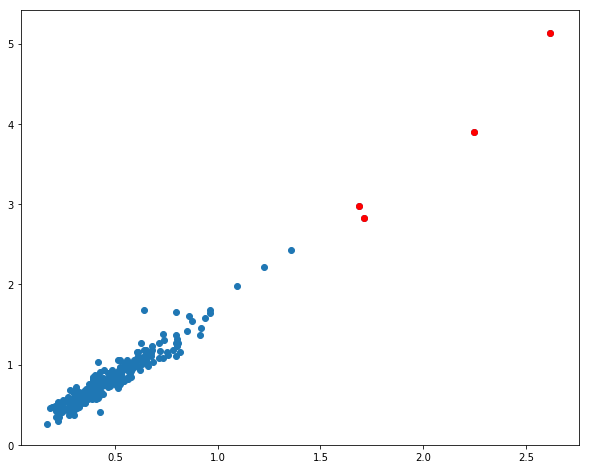

In [679]:
def plot_outliers(data, exercise, ids, features):
    
    data = data[data['exercise_clean']==exercise]
    
    plt.figure(figsize=(10, 8))
    
    plt.scatter(data[features[0]], data[features[1]])  # plot all points
    for user in ids:
        plt.scatter(data[data['userID']==user][features[0]], 
                    data[data['userID']==user][features[1]], 
                    c='r')  # plot interesting points in red again   
    plt.show()

ids = list(deadlift_clusters[deadlift_clusters["Cluster"]==1]['userID'])
plot_outliers(df_train, 'deadlift', ids, ['AvgVel_mean', 'PeakVel_mean'])

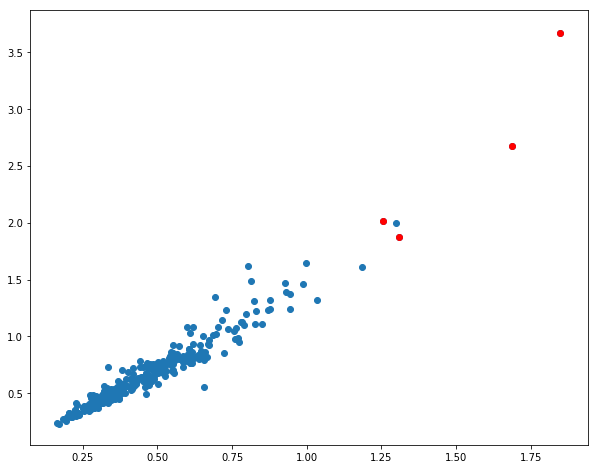

In [680]:
ids = list(bench_clusters[bench_clusters["Cluster"]==2]['userID'])
plot_outliers(df_train, 'bench', ids, ['AvgVel_mean', 'PeakVel_mean'])

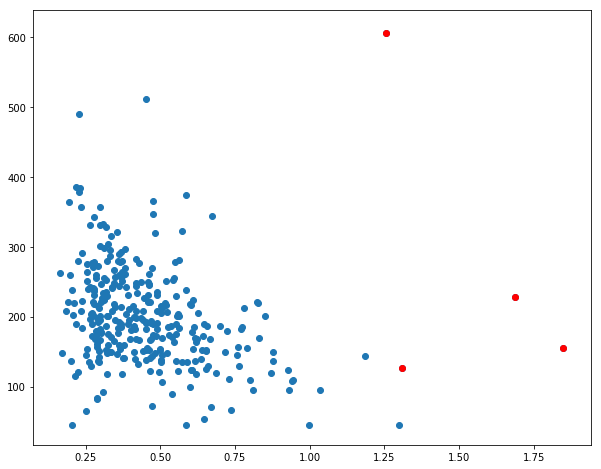

In [692]:
plot_outliers(df_train, 'bench', ids, ['AvgVel_mean', 'weight_lbs_mean'])

## PCA

In [730]:
def make_pca(data, n_comp):
    """Fits Principal Component Transformation on input data
    
    Args: 
        data: input dataset
        n_comp: int, number of components to keep
    
    Returns:
        PCA object
    """
    
    return PCA(n_components=n_comp).fit(data)


def plot_pca_contribution(data, exercise, n_min=2, n_max=8):
    """Fits PCA to input data and plots cumulative ratio 
    of explained variance by principal component
    
    Args:
        data: input dataset
        n: int, number of components to keep
    """
    
    data=data[data['exercise_clean']==exercise].drop(grouping_vars, axis=1)
    n_comp = data.shape[1]
    pca_explvar = make_pca(data, n_comp).explained_variance_ratio_
    pca_explvar_cum = np.insert(np.cumsum(pca_explvar), 0, 0)
    pc_min = pca_explvar_cum[n_min]
    pc_max = pca_explvar_cum[n_max]
    print("="*80)
    print(f"For {exercise} {n_min} PCs explain {pc_min*100:.1f}%", end = '')
    print(f" and {n_max} PCs explain {pc_max*100:.1f}%")
    plt.figure(figsize=(10, 5))
    plt.plot(pca_explvar_cum)
    alpha = 0.25
    plt.axvline(x=n_min, linestyle = '--', color = 'r', alpha = alpha, 
                label = f"{n_min} Principal Components")
    plt.axhline(y=pc_min, linestyle = '--', color = 'r', alpha = alpha)
    plt.axvline(x=n_max, linestyle = '--', color = 'g', alpha = alpha, 
                label = f"{n_max} Principal Components")
    plt.axhline(y=pc_max, linestyle = '--', color = 'g', alpha = alpha)
    plt.title(f"Cumulative Variance Explained by Principal Components for {exercise}",
             fontsize = 16)
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage of variance explained")
    plt.legend(fontsize = 14)
    plt.show()

For bench 2 PCs explain 69.1% and 4 PCs explain 90.2%


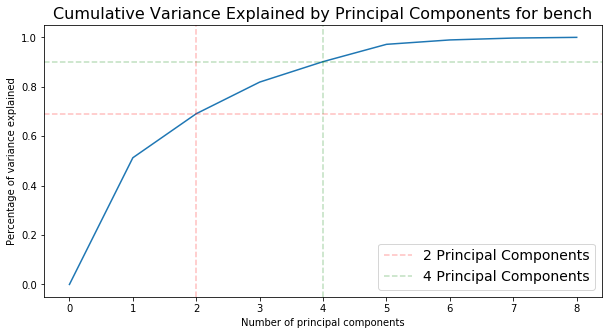

For squat 2 PCs explain 63.8% and 4 PCs explain 88.0%


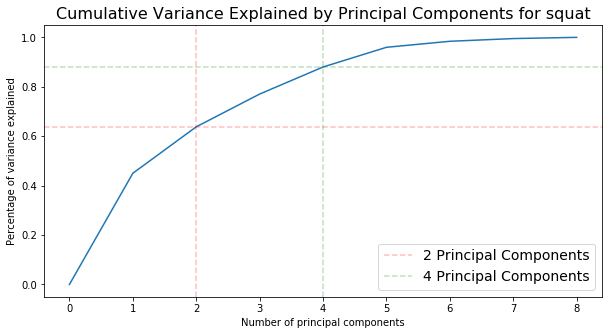

For deadlift 2 PCs explain 67.4% and 4 PCs explain 89.8%


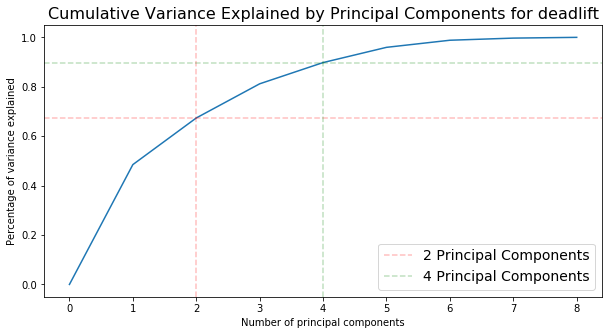

In [731]:
plot_pca_contribution(df_train_pr, 'bench', n_max=4)
plot_pca_contribution(df_train_pr, 'squat', n_max=4)
plot_pca_contribution(df_train_pr, 'deadlift', n_max=4)

In [721]:
def stack_pca_data(data, n_pca):
    
    data_out = np.empty(shape=(0,n_pca))
    for ex in exercises:
        pca_data = data[data['exercise_clean']==ex].drop(grouping_vars, axis=1)
        pca_data = make_pca(pca_data, n_pca).transform(pca_data)
        print(pca_data.shape)
        data_out = np.concatenate((data_out, pca_data), axis = 0)
    print(data_out.shape)
        
    return data_out

df_train_pca2 = stack_pca_data(df_train_pr, 2)
df_train_pca3 = stack_pca_data(df_train_pr, 3)

(323, 2)
(247, 2)
(311, 2)
(881, 2)
(323, 3)
(247, 3)
(311, 3)
(881, 3)


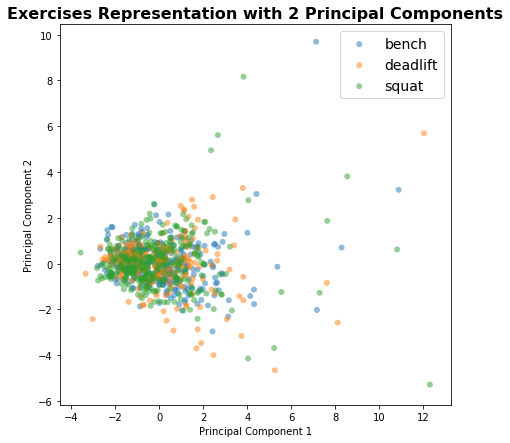

In [722]:
def make_2pca_plot(pca_data):
    """Plots PCA transformed data for two types of mushrooms
    
    Args:
        data: input dataset
        labs: array of class labels (values = (0,1))
        n_comp: int, number of principal components to keep
    """
    
    plt.figure(figsize=(7, 7))
    for ex in exercises:
        plt.scatter(pca_data[exercise_names==ex,0],pca_data[exercise_names==ex,1], 
                  alpha=0.5,  edgecolor='none', label = ex)
    plt.title(f"Exercises Representation with 2 Principal Components", 
              fontsize=16, fontweight='bold')
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(fontsize=14)
    plt.show()
    
make_2pca_plot(df_train_pca2)

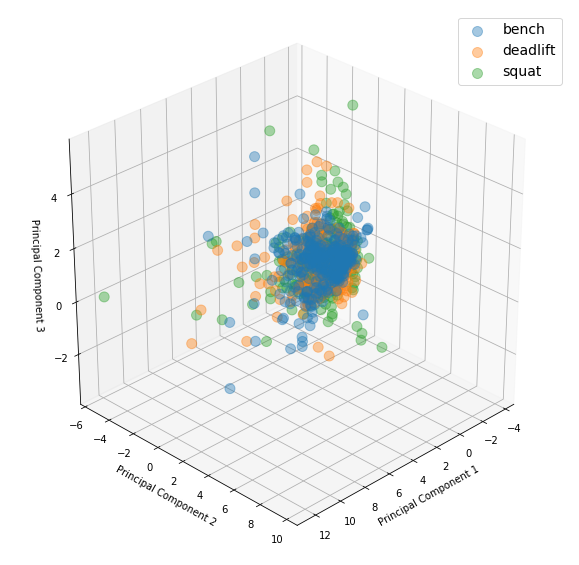

In [727]:
def make_3pca_plot(pca_data):
    """Plots PCA transformed data for two types of mushrooms
    
    Args:
        data: input dataset
        labs: array of class labels (values = (0,1))
        n_comp: int, number of principal components to keep
    """
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    for ex in exercises:
        ax.scatter(pca_data[exercise_names==ex,0],
                 pca_data[exercise_names==ex,1], 
                 pca_data[exercise_names==ex,2],
                   label=ex,
                alpha = 0.4, s=100)
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    ax.view_init(azim=45)
    plt.legend(fontsize=14)
    plt.show()
    
make_3pca_plot(df_train_pca3)

## K Means

In [ ]:
def make_kmeans(data, ncl):
    """Fits kmeans on input dataset
    
    Args:
        data: input dataset
        ncl: int, number of clusters
    
    Returns:
        KMeans object
    """  
    
    return KMeans(n_clusters = ncl, random_state = 22).fit(data)

In [732]:
check_frequency(bench_clusters["Cluster"])


Cluster has 3 unique values
Top 10 values are:
3    170
1    149
2      4
Name: Cluster, dtype: int64


In [ ]:
ids = list(bench_clusters[bench_clusters["Cluster"]==2]['userID'])

In [734]:
df_train_pca2[:5]

array([[-1.33272,  0.27403],
       [-0.13204,  0.25509],
       [ 0.31854, -0.70455],
       [-0.87008, -0.12959],
       [-1.17164, -0.65059]])

## Hierarchical Clustering Example

All credit goes to:
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [435]:
features_for_clustering = ['ROM_mean', 'PeakVelLoc_std']
X = df_train_pr[df_train_pr['exercise_clean'] == 'bench'][features_for_clustering].values
X.shape

(247, 2)

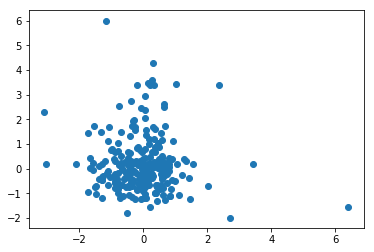

In [436]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [447]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
# Cophenetic Correlation Coefficient the closer the value is to 1, the better the clustering preserves the original distances
# Methods ‘centroid’, ‘median’ and ‘ward’ are correctly defined only if Euclidean pairwise metric is used
linkages = ['ward', 'single', 'complete', 'average', 'weighted', 'centroid', 'median']
distances = ['euclidean', 'cityblock', 'cosine', 'correlation']
for d in distances:
    for l in linkages:
        Z = linkage(X, l)
        c, coph_dists = cophenet(Z, pdist(X, d))
        print(d, l, round(c,2))
#         print(coph_dists.shape)

euclidean ward 0.56
euclidean single 0.75
euclidean complete 0.74
euclidean average 0.81
euclidean weighted 0.77
euclidean centroid 0.84
euclidean median 0.51
cityblock ward 0.56
cityblock single 0.75
cityblock complete 0.73
cityblock average 0.8
cityblock weighted 0.75
cityblock centroid 0.82
cityblock median 0.51
cosine ward 0.42
cosine single 0.02
cosine complete 0.23
cosine average 0.23
cosine weighted 0.29
cosine centroid 0.14
cosine median 0.56
correlation ward 0.38
correlation single 0.01
correlation complete 0.14
correlation average 0.18
correlation weighted 0.19
correlation centroid 0.08
correlation median 0.39


In [456]:
# but only ward gets a distinguished enough clustering
Z = linkage(X, 'ward')
c, coph_dists = cophenet(Z, pdist(X, 'euclidean'))
Z.shape

(246, 4)

In [473]:
# [idx1, idx2, dist, sample_count]
Z[:9]

array([[ 129.     ,  190.     ,    0.00078,    2.     ],
       [  17.     ,  198.     ,    0.00402,    2.     ],
       [ 105.     ,  156.     ,    0.00774,    2.     ],
       [ 104.     ,  203.     ,    0.00974,    2.     ],
       [ 168.     ,  240.     ,    0.01238,    2.     ],
       [   5.     ,   33.     ,    0.01786,    2.     ],
       [  70.     ,   74.     ,    0.02041,    2.     ],
       [ 161.     ,  172.     ,    0.02351,    2.     ],
       [ 115.     ,  196.     ,    0.02656,    2.     ]])

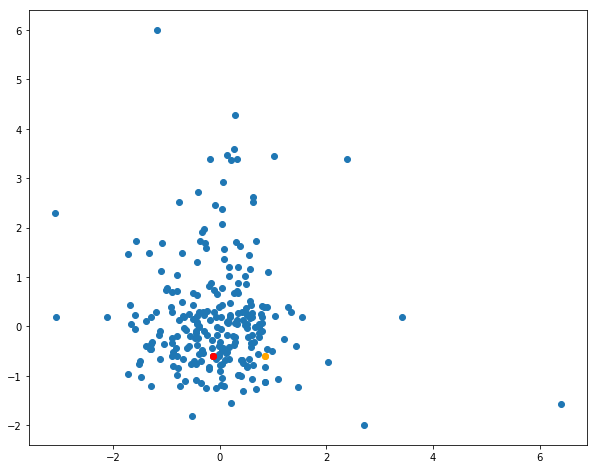

In [478]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1])  # plot all points
plt.scatter(X[[129, 190],0], X[[129, 190],1], c='r')  # plot interesting points in red again
plt.scatter(X[[17, 198],0], X[[129, 190],1], c='orange')  # plot interesting points in red again
plt.show()

In [482]:
# distances at the last 4 merges:
Z[-10:,2]

array([  4.04456,   4.30971,   5.12386,   5.54264,   7.30187,   7.74825,
         8.70046,   9.18452,  12.21339,  19.94732])

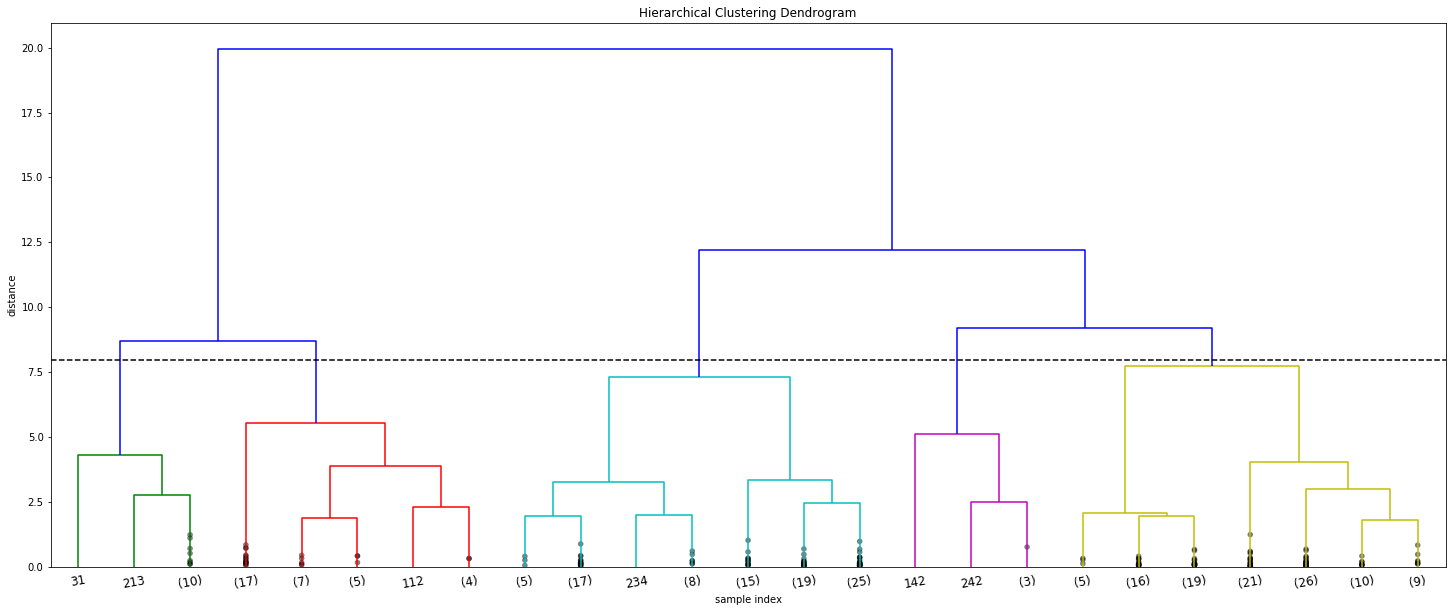

In [526]:
max_d = 0.4*max(Z[:,2])
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=10.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    color_threshold = max_d,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.axhline(y=max_d, c='k', ls='--')
plt.show()

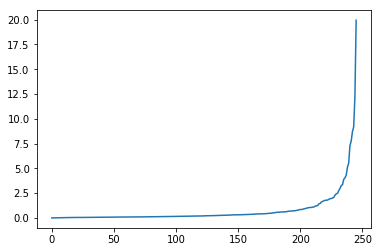

In [486]:
# visualizing distances
plt.plot(Z[:,2])

In [527]:
clusters = pd.Series(fcluster(Z, max_d, criterion='distance'))
check_frequency(clusters)


None has 5 unique values
Top 10 values are:
5    106
3     90
2     34
1     12
4      5
dtype: int64


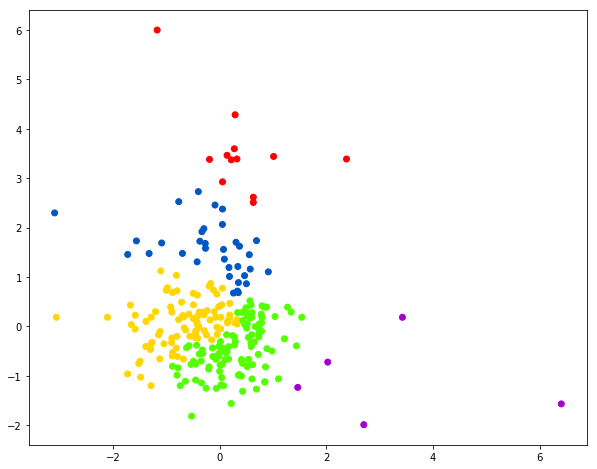

In [528]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.show()